# Automated trading system based on the Q-learning algorithm


### Ressources

https://github.com/llSourcell/Q-Learning-for-Trading : Siraj raval video code

https://medium.freecodecamp.org/an-introduction-to-reinforcement-learning-4339519de419 : free code camp tutorial, RL

https://medium.freecodecamp.org/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe : freecodecamp Q-learning

http://www.wildml.com/2018/02/introduction-to-learning-to-trade-with-reinforcement-learning/ : trading btc with RL

## Loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
filenames = ["bank_of_america.csv", "ge.csv","daily_IBM.csv"]
filedir = "Data/"

boa = pd.read_csv(filedir + filenames[0])
ge = pd.read_csv(filedir + filenames[1])

ibm = pd.read_csv(filedir + filenames[2])


### Looking at the data

In [3]:
print(boa.shape)
print(ge.shape)
print(ibm.shape)
ibm.head()

(1257, 7)
(1257, 7)
(4526, 6)


,timestamp,open,high,low,close,volume
0,2017-12-27,152.95,153.15,152.61,153.0385,1151259
1,2017-12-26,152.51,153.86,152.50,152.8300,2478972
2,2017-12-22,151.71,153.00,151.50,152.5000,2982114
3,2017-12-21,153.17,153.46,151.49,151.5000,4126632
4,2017-12-20,153.65,153.89,152.78,152.9500,3771425


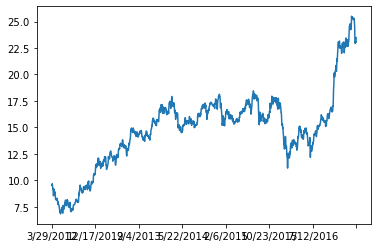

In [4]:
plt.plot(boa.Date,boa.Close)
plt.xticks(np.linspace(0,boa.shape[0],8,endpoint=True))
plt.show()

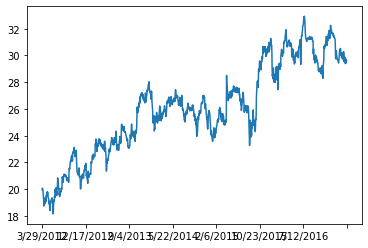

In [5]:
plt.plot(ge.Date,ge.Close)
plt.xticks(np.linspace(0,boa.shape[0],8,endpoint=True))
plt.show()

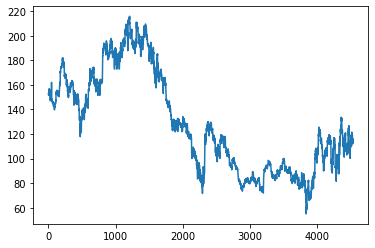

In [6]:
plt.plot(range(len(ibm["close"])),ibm["close"])
#plt.xticks(np.linspace(0,boa.shape[0],8,endpoint=True))
plt.show()

### Data processing

The data contains a total of 7 columns, in our case we will only keep the date and close which correspond to the share price after the market has closed.

This becomes simple time series data, where the value of the share can rise and fall over time. The goal of our trading algorithm will be to maximize the end profits.

#### Train test split
We perform a simple train test split on the data so that we can test our final algorithm to make sure that it didnt just overfit to the previously seen data

In [7]:
split_ratio = 0.7

samples_train = int(boa.shape[0] * split_ratio)


train_boa = boa[:samples_train]
test_boa = boa[samples_train:]

train_ge = ge[:samples_train]
test_ge = ge[samples_train:]

print(len(train_ge))

879


### Steps for Q-learning:

For our algorithm, we have an agent that has a total of 5000$ to use to buy shares, he can choose from 3 different actions:

1) Buy

2) Sell

3) Hold

We need to create a Q-table that can map each state and action pair to a Q value. The issue with our case is that our data is more or less continuous, and q-learning requires a finite state space to function or else we would use deep-q-learning. To limit the state space we could round the close values to the integer above but this could maybe limit the end performance of the algorithm

### defining the reward function

A proper reward function is aso important in RL, this will heavily influence the end behavior of our agent. Our goal here is to make as much profit as possible by the end so we will implement the profit as a reward for our agent. Furthermore, in order to have our agent favour more long term behaviours, we will use a high discounting factor $\gamma$ for long term rewards prioritization. But, we also need to have a reward that can be given at each step. For the second part of the reward, we can look at the number of shares held, this is because we want our agent to make profits which means that he will need to buy shares, although, this could also result in a problematic behaviour where the agent will buy as many shares as he can because he wants to maximize the reward function. 

As a good starting point, lets simply begin by using the current profits as a reward, that way with a high discount factor the agent will tr to maximize profits over time. 

### Building our state/action space:
We are going to need a Q_table that maps a state action pair to a corresponding q_value which indicates the 'quality' of an action for a given state. 

- State Space:

[n° of stocks owned, cash balance, current close price]

    - close_price: range(min, max) discretized to a step (1.0 or 0.1)
    - n° stocks  : 2*init_cash_bal // max close
    - cash_bal   : 2*init_cash_bal (stride of 100)

In [8]:
class State:
    """ this class is to store the sub states that will be in our environment
        these sub states are composed of a min max range and a step factor
    """

    def __init__(self, low, high, step,name):
        self.low = low
        self.high = high
        self.step = step
        self.name = name

    def get_state_dim(self):
        """ returns the dimensions size of the sub state space
        """
        return int(((self.high - self.low) // self.step))

    def get_state_table(self):
        """ returns the state table for this sub state class, the table will be composed of all of 
            the possible sub states in ascending order
        """
        states = [state for state in range(self.low, self.high, self.step)]

        return states

    def get_state_index(self, sub_state):
        """ returns the index of where the specific sub state is
            used for finding the correct sub state combination in our Q-table
        """
        i = (abs(sub_state - self.low)//self.step)
        if i > self.get_state_dim() or i < 0:
            print("out of bounds index access at i=",i,"for class",self.name,"with value:",sub_state)
        return int(i-1)

In [9]:
# ACTIONS
actions = {0: "buy", 1: "sell", 3: "hold"}
n_actions = len(actions)



# STATES

# 1 closing price
# gets max close value between the two stocks data
max_close = np.max([boa["Close"].max(), ge["Close"].max(),ibm["close"].max()])
min_close = np.min([boa["Close"].min(), ge["Close"].min(),ibm["close"].min()])
close_step = 1.0  # we should divide our data to fit this discretization step

# close delta

deltas_ibm = np.array([ibm["close"][tt] - ibm["close"][t]  for tt,t in zip(range(0,len(ibm.close)),range(1,len(ibm.close)-1)) ])
deltas_boa = np.array([boa["Close"][tt] - boa["Close"][t]  for tt,t in zip(range(0,len(boa.Close)),range(1,len(boa.Close)-1)) ])
deltas_ge = np.array([ge["Close"][tt] - ge["Close"][t]  for tt,t in zip(range(0,len(ge.Close)),range(1,len(ge.Close)-1)) ])

min_delta = np.min([deltas_boa.min(),deltas_ge.min(),deltas_ibm.min()])
max_delta = np.max([deltas_boa.max(),deltas_ge.max(),deltas_ibm.max()])
delta_step = 0.1

delta_state = State(min_delta,max_delta,delta_step,"delta")


min_close = (min_close//close_step)*close_step
max_close = (max_close//close_step)*close_step
print(max_close)
print(min_close)


close_range = (max_close - min_close) // close_step

close_state = State(min_close,max_close,close_step,"close")


# 2 nb stocks
#stock_range =  initial_cash // min_close
min_stock = 0
max_stock = 5000 // min_close
stock_step = 50
stock_range = (max_stock - min_stock) // stock_step

stock_state = State(min_stock,max_stock,stock_step,'stock')

# 3 cash balance
min_cash = 0
max_cash = 5 * 5000
cash_step = 1000
cash_range = (max_cash - min_cash) // cash_step

cash_state = State(min_cash,max_cash,cash_step,'cash')

# range of states by dividing the max state by a step factor, we are discretzing the state space
state_range = (int)(stock_range * cash_range * delta_state.get_state_dim())
print(state_range)

print(close_state.get_state_dim())
print(stock_state.get_state_dim())
print(cash_state.get_state_dim())
print(delta_state.get_state_dim())

215.0
6.0
122000
209
16
25
305


###  Q_learning Algorithm

Now we will start onto the implementation of the Q-learning algorithm, the necesary preparations for this should have already been made before.

We begin by initializing our q-table, we build it with our state space in the lines and our action space as our columns. All of the values will be initialized at 0 at the begining and wil be updated as our agent explores the environment.

In [10]:
q_table = np.zeros((state_range, n_actions))
print(q_table.shape)

(122000, 3)


### Making the portfolio class
This class will handle all of our assets and handle the various methods to buy or sell 

In [11]:
print(6.35 / 2 )
print(5.52 / 1 )

print(6.35 // 2 )
print(5.52 // 1 )

3.175
5.52
3.0
5.0


In [12]:
class Portfolio:
    """
    this is a simple class that we will use to keeptrack of or current assets
    the class will store all of our assets: cash and stock shares  
    """
    
    def __init__(self,close_state,cash_state,stock_state, initial_cash=5000):
        #we will also store the states of the model
        self.close_state =close_state
        self.cash_state= cash_state
        self.stock_state = stock_state
        
        self.initial_cash = initial_cash
        self.cash_bal = initial_cash
        self.stocks = 0
        self.old_val= initial_cash

        
    def buy(self, share_price, share_amount=0):
        """buys a number of shares at a given price
            if no share amount is specified then buy as many as possible
        """
        if share_amount == 0:
            # buy as many shares as possible
            poss_shares =  self.cash_bal // share_price

            # check that we can at least buy one share
            if poss_shares > 0:
                self.stocks += poss_shares
                self.cash_bal -= (share_price*poss_shares)
                return True
            else:
                return False
        else:
            # buy the given amount
            # if we have enough cash
            if self.cash_bal >= (share_amount*share_price):
                # we can buy the specified amount
                self.stocks += share_amount
                self.cash_bal -= (share_amount*share_price)
                return True
            else:
                # we cant buy that much, buy as many as possible with current cash
                poss_shares =  self.cash_bal // share_price

                if poss_shares > 0:
                    self.stocks += poss_shares
                    self.cash_bal -= (share_price*poss_shares)
                    return True
                else:
                    return False

    def sell(self, share_price, share_amount=0):
        """method for selling shares, if the share amount is not specified,
           we will sell of of the current shares that we have
        """
        if self.stocks > 0:

            if share_amount == 0:
                # sell everything
                self.cash_bal += (self.stocks*share_price)
                self.stocks = 0
                return True
            else:
                # sell the amount specified
                if self.stocks >= share_amount:

                    self.cash_bal += (share_amount*share_price)
                    self.stocks -= share_amount
                    return True
                else:
                    # sell all that we have left
                    self.cash_bal += (self.stocks*share_price)
                    self.stocks = 0
                    return True
        else:
            return False
    def hold(self):
        return True

    def get_portfolio_value(self, share_value):
        return ((self.stocks*share_value) + self.cash_bal)

    def get_cash(self):
        return ((self.cash_bal//self.cash_state.step)*self.cash_state.step)

    # 
    def get_stock(self):
        return ((self.stocks//self.stock_state.step)*self.stock_state.step)
    
    def get_close(self,close_price):
        
        return ((close_price//self.close_state.step)*close_state.step)
    
    def profits(self,close_price):
        return (self.get_portfolio_value(close_price) - self.initial_cash)
    
    def reward(self,share_price):
        """ returns the current reward, this reward is evaluated at a given state
            and corresponds to the current profits that the agent has made so far
        """
        
        curr = self.get_portfolio_value(share_price)
        #print("curr:",curr,"last:",self.old_val)
        reward = ( curr - self.old_val)
        if reward < 0:
            reward *= -reward
        else:
            reward *= reward
            
        self.old_val = curr
        return reward
    

### Actual Q-learning algo:


![title](img/q_process.png)

![title](img/q_update.png)

In [13]:
def init_q_table(close_state,stock_state,cash_state,actions):
    """inits our q table, the state space will be decomposed in all of the dfferent state combinations
        states are in the lines and actions in the columns
    """
    state_dim =(int)( close_state.get_state_dim() * stock_state.get_state_dim() * cash_state.get_state_dim())
    
    state_table = np.zeros((close_state.get_state_dim(),stock_state.get_state_dim() ,cash_state.get_state_dim(), len(actions)))
    
    print(state_table.shape)
    
    return state_table


In [14]:
def get_state_index(cash_state,stock_state,close_state,state):
    state_index =  cash_state.get_state_index(state[2])
    state_index += (cash_state.get_state_dim() * stock_state.get_state_index(state[1]))
    state_index += (stock_state.get_state_dim()**2 + cash_state.get_state_dim()) * close_state.get_state_index(state[0])
    
    return (int(state_index))

In [26]:
def train(data,close_state,stock_state,cash_state,actions):
    """ q-learning training function, trains an agent using q learning on financial data
        the hyperparameters are set inside of the function 
    """
    # hyperparameters
    n_episodes = 2500

    learning_rate = 0.25
    discount_factor = 0.9 #high gamma ==> long term reward strategy
    
    epsilon = 1.0 # to implement exploration strategy
    epsilon_min = 0.0001
    epsilon_decay = 0.990 #value to make epsilon decay over time so we explore less 

    #build q_table based on state and action space 
    q_table = init_q_table(delta_state,stock_state,cash_state,actions)

    profits = []
    
    buy_amount = 25
    sell_amount = 25

    #for a given number of episodes
    for episode in range(n_episodes):
        #reset portfolio
        portfolio = Portfolio(delta_state, cash_state, stock_state)
        random = 0
        calculated = 0
        prev_close = data[0]

        #go thorugh all financial data
        for i,close in enumerate(data):
            
            #get our current state, close is part of our state
            state = (portfolio.get_close(close-prev_close),portfolio.get_stock(), portfolio.get_cash())
            prev_close = close
            state_index = [close_state.get_state_index(state[0]),stock_state.get_state_index(state[1]),cash_state.get_state_index(state[2])] #index of state combination in q table

            ###########################################################################
            #1 choose action, sample randomly and compare to epsilon (for exploration)#
            ###########################################################################
            if np.random.uniform() < epsilon:
                #choose random action
                act = np.random.randint(3,size=1)
                random +=1
            else:
                # use q table to find best action
                calculated += 1
                #print(state_index)
                #print(q_table[state_index])
                act = np.argmax(q_table[state_index[0]][state_index[1]][state_index[2]])
                #print(act)

            ###########################################################################
            #2 take action
            ###########################################################################
            if act == 0:
                #buy
                portfolio.buy(close,buy_amount)
            elif act == 1:
                #sell
                portfolio.sell(close,sell_amount)
            else:
                #hold, do nothing
                portfolio.hold()
                
            ##########################################################################
            #3 calculate reward
            ##########################################################################
            
            reward = portfolio.reward(close)
            
            #########################################################################
            #4 update q-table, use bellman equation like in figure above
            ###########################################################################
            #get some info on next possible state
            if i < len(data) - 1:
                state_prime = (portfolio.get_close(data[i+1] -close),portfolio.get_stock(), portfolio.get_cash())
                prime_state_index =[close_state.get_state_index(state_prime[0]),stock_state.get_state_index(state_prime[1]),cash_state.get_state_index(state_prime[2])] #index of state combination in q table
                #print(prime_state_index)
                q_prime = np.max(q_table[prime_state_index[0]][prime_state_index[1]][prime_state_index[2]]) #gets max q value in next state, used in equation bellow
            else:
                state_prime = (portfolio.get_close(data[i] - close),portfolio.get_stock(), portfolio.get_cash())
                prime_state_index =[close_state.get_state_index(state_prime[0]),stock_state.get_state_index(state_prime[1]),cash_state.get_state_index(state_prime[2])]#index of state combination in q table
                q_prime = np.max(q_table[prime_state_index[0]][prime_state_index[1]][prime_state_index[2]])#gets max q value in next state, used in equation bellow

            #formula above
            q_table[state_index[0]][state_index[1]][state_index[2]][act] = ((1-learning_rate)*q_table[state_index[0]][state_index[1]][state_index[2]][act])  + (learning_rate*(reward + (discount_factor* q_prime) ))

        ##change epsilon value to stop exploration strategy progressively
        if epsilon >= epsilon_min:
            epsilon *= epsilon_decay
        
        #store final profits in table
        
        profits.append(portfolio.profits(data[-1]))
        print("finished episode",episode,"with",profits[-1],"profits. random count:",random,"calculated count:",calculated)

        
    
    #plotting the training data
    plt.figure(figsize=(20,8))
    plt.plot(range(len(profits)),profits)
    plt.show()
    
    print("min reward:", np.min(profits),"max reward",np.max(profits), "avg reward over",n_episodes,"epsiodes",np.average(profits))
     
    return q_table

In [16]:
def train_mix(data1,data2,close_state,stock_state,cash_state,actions):
    """ q-learning training function, trains an agent using q learning on financial data
        the hyperparameters are set inside of the function 
    """
    # hyperparameters
    n_episodes = 5000

    learning_rate = 0.2
    discount_factor = 0.9 #high gamma ==> long term reward strategy
    
    epsilon = 1.0 # to implement exploration strategy
    epsilon_min = 0.001
    epsilon_decay = 0.990 #value to make epsilon decay over time so we explore less 

    #build q_table based on state and action space 
    q_table = init_q_table(close_state,stock_state,cash_state,actions)

    profits1 = []
    profits2 = []

    buy_amount = 50
    sell_amount = 50

    count = 0
    
    #for a given number of episodes
    for episode in range(n_episodes):
        #reset portfolio
        portfolio = Portfolio(close_state, cash_state, stock_state)
        random = 0
        calculated = 0
        
        count+=1
        
        if count%2==0:
            data=data1
        else:data=data2

        #go thorugh all financial data
        for i,close in enumerate(data):
            
            #get our current state, close is part of our state
            state = (portfolio.get_close(close),portfolio.get_stock(), portfolio.get_cash())
            state_index = [delta_state.get_state_index(state[0]),stock_state.get_state_index(state[1]),cash_state.get_state_index(state[2])] #index of state combination in q table

            ###########################################################################
            #1 choose action, sample randomly and compare to epsilon (for exploration)#
            ###########################################################################
            if np.random.uniform() < epsilon:
                #choose random action
                act = np.random.randint(3,size=1)
                random +=1
            else:
                # use q table to find best action
                calculated += 1
                #print(state_index)
                #print(q_table[state_index])
                act = np.argmax(q_table[state_index[0]][state_index[1]][state_index[2]])
                #print(act)

            ###########################################################################
            #2 take action
            ###########################################################################
            if act == 0:
                #buy
                portfolio.buy(close,buy_amount)
            elif act == 1:
                #sell
                portfolio.sell(close,sell_amount)
            else:
                #hold, do nothing
                portfolio.hold()
                
            ##########################################################################
            #3 calculate reward
            ##########################################################################
            
            reward = portfolio.reward(close)
            
            #########################################################################
            #4 update q-table, use bellman equation like in figure above
            ###########################################################################
            #get some info on next possible state
            if i < len(data) - 1:
                state_prime = (portfolio.get_close(data[i+1]),portfolio.get_stock(), portfolio.get_cash())
                prime_state_index =[delta_state.get_state_index(state_prime[0]),stock_state.get_state_index(state_prime[1]),cash_state.get_state_index(state_prime[2])] #index of state combination in q table
                #print(prime_state_index)
                q_prime = np.max(q_table[prime_state_index[0]][prime_state_index[1]][prime_state_index[2]]) #gets max q value in next state, used in equation bellow
            else:
                state_prime = (portfolio.get_close(data[i]),portfolio.get_stock(), portfolio.get_cash())
                prime_state_index =[delta_state.get_state_index(state_prime[0]),stock_state.get_state_index(state_prime[1]),cash_state.get_state_index(state_prime[2])]#index of state combination in q table
                q_prime = np.max(q_table[prime_state_index[0]][prime_state_index[1]][prime_state_index[2]])#gets max q value in next state, used in equation bellow

            #formula above
            q_table[state_index[0]][state_index[1]][state_index[2]][act] = ((1-learning_rate)*q_table[state_index[0]][state_index[1]][state_index[2]][act] ) + (learning_rate*(reward + (discount_factor* q_prime) ))

        ##change epsilon value to stop exploration strategy progressively
        if epsilon >= epsilon_min:
            epsilon *= epsilon_decay
        
        #store final profits in table
        if count%2 ==0:
            profits1.append(portfolio.profits(data[-1]))
            print("finished episode",episode,"with",profits1[-1],"profits. random count:",random,"calculated count:",calculated)
        else:
            profits2.append(portfolio.profits(data[-1]))
            print("finished episode",episode,"with",profits2[-1],"profits. random count:",random,"calculated count:",calculated)
        
        
    
    #plotting the training data
    plt.figure(figsize=(20,8))
    plt.plot(range(len(profits1)),profits1)
    plt.show()
    
    print("min reward:", np.min(profits1),"max reward",np.max(profits1), "avg reward over",n_episodes,"epsiodes",np.average(profits1))
    
    
    plt.figure(figsize=(20,8))
    plt.plot(range(len(profits2)),profits2)
    plt.show()
    
    print("min reward:", np.min(profits2),"max reward",np.max(profits2), "avg reward over",n_episodes,"epsiodes",np.average(profits2))
    return q_table

### Training on both sets of data
Now we can move on to the training phase of the q-learning algorithm. 

(305, 16, 25, 3)
finished episode 0 with 220.99250000002758 profits. random count: 4526 calculated count: 0
finished episode 1 with -2174.9999999999923 profits. random count: 4486 calculated count: 40
finished episode 2 with 632.4675000000034 profits. random count: 4455 calculated count: 71
finished episode 3 with -1301.4739000000036 profits. random count: 4393 calculated count: 133
finished episode 4 with 3036.787499999993 profits. random count: 4325 calculated count: 201
finished episode 5 with -2934.594999999998 profits. random count: 4293 calculated count: 233
finished episode 6 with -792.5500000000065 profits. random count: 4265 calculated count: 261
finished episode 7 with -1045.1049999999905 profits. random count: 4228 calculated count: 298
finished episode 8 with -1282.4600000000028 profits. random count: 4175 calculated count: 351
finished episode 9 with -508.67749999999796 profits. random count: 4145 calculated count: 381
finished episode 10 with -3133.3023999999978 profits. 

finished episode 87 with -1719.719999999999 profits. random count: 1889 calculated count: 2637
finished episode 88 with 564.5800000000081 profits. random count: 1902 calculated count: 2624
finished episode 89 with 1123.8799999999965 profits. random count: 1829 calculated count: 2697
finished episode 90 with 631.760000000013 profits. random count: 1806 calculated count: 2720
finished episode 91 with 1615.8143 profits. random count: 1838 calculated count: 2688
finished episode 92 with 1049.935000000025 profits. random count: 1817 calculated count: 2709
finished episode 93 with -2982.9149999999972 profits. random count: 1787 calculated count: 2739
finished episode 94 with 3987.7100000000046 profits. random count: 1785 calculated count: 2741
finished episode 95 with 360.1974999999993 profits. random count: 1743 calculated count: 2783
finished episode 96 with 26.302499999997053 profits. random count: 1675 calculated count: 2851
finished episode 97 with 275.25749999998425 profits. random cou

finished episode 174 with -1546.9049999999916 profits. random count: 760 calculated count: 3766
finished episode 175 with 2355.4875000000047 profits. random count: 751 calculated count: 3775
finished episode 176 with 21.502500000007785 profits. random count: 744 calculated count: 3782
finished episode 177 with 1230.715000000012 profits. random count: 791 calculated count: 3735
finished episode 178 with 154.11249999999745 profits. random count: 750 calculated count: 3776
finished episode 179 with -2792.62 profits. random count: 757 calculated count: 3769
finished episode 180 with 482.97079999999096 profits. random count: 749 calculated count: 3777
finished episode 181 with 4877.757599999995 profits. random count: 767 calculated count: 3759
finished episode 182 with 882.1399999999949 profits. random count: 737 calculated count: 3789
finished episode 183 with -558.5150000000094 profits. random count: 733 calculated count: 3793
finished episode 184 with -858.4594000000125 profits. random c

finished episode 262 with 1117.87000000001 profits. random count: 314 calculated count: 4212
finished episode 263 with 57.39280000000599 profits. random count: 331 calculated count: 4195
finished episode 264 with -775.3670000000056 profits. random count: 312 calculated count: 4214
finished episode 265 with 3929.4902 profits. random count: 312 calculated count: 4214
finished episode 266 with 2908.724999999995 profits. random count: 352 calculated count: 4174
finished episode 267 with -666.2625000000089 profits. random count: 276 calculated count: 4250
finished episode 268 with 1982.4799999999996 profits. random count: 313 calculated count: 4213
finished episode 269 with 2773.3324999999913 profits. random count: 315 calculated count: 4211
finished episode 270 with 816.4449999999979 profits. random count: 311 calculated count: 4215
finished episode 271 with 3824.5000000000146 profits. random count: 325 calculated count: 4201
finished episode 272 with 6171.9699999999975 profits. random cou

finished episode 350 with 105.22000000000116 profits. random count: 139 calculated count: 4387
finished episode 351 with 5599.090000000007 profits. random count: 132 calculated count: 4394
finished episode 352 with 5483.550000000001 profits. random count: 127 calculated count: 4399
finished episode 353 with 7107.159999999996 profits. random count: 125 calculated count: 4401
finished episode 354 with 7360.545000000009 profits. random count: 135 calculated count: 4391
finished episode 355 with 5216.992500000006 profits. random count: 130 calculated count: 4396
finished episode 356 with 4874.704999999998 profits. random count: 121 calculated count: 4405
finished episode 357 with 6802.775000000003 profits. random count: 116 calculated count: 4410
finished episode 358 with 2692.637499999997 profits. random count: 119 calculated count: 4407
finished episode 359 with 5360.729999999998 profits. random count: 110 calculated count: 4416
finished episode 360 with 2718.6675000000105 profits. rando

finished episode 438 with 7662.9125000000095 profits. random count: 64 calculated count: 4462
finished episode 439 with 2241.1875 profits. random count: 56 calculated count: 4470
finished episode 440 with 1215.5575 profits. random count: 56 calculated count: 4470
finished episode 441 with 13068.969999999994 profits. random count: 54 calculated count: 4472
finished episode 442 with 3081.58 profits. random count: 41 calculated count: 4485
finished episode 443 with 3816.159999999996 profits. random count: 56 calculated count: 4470
finished episode 444 with 6449.8099999999995 profits. random count: 50 calculated count: 4476
finished episode 445 with 1004.9999999999945 profits. random count: 54 calculated count: 4472
finished episode 446 with 1598.139999999993 profits. random count: 50 calculated count: 4476
finished episode 447 with 3158.110000000004 profits. random count: 44 calculated count: 4482
finished episode 448 with -667.5400000000009 profits. random count: 52 calculated count: 447

finished episode 528 with 7181.752500000002 profits. random count: 17 calculated count: 4509
finished episode 529 with 8285.022499999997 profits. random count: 22 calculated count: 4504
finished episode 530 with 13006.504999999994 profits. random count: 16 calculated count: 4510
finished episode 531 with 3594.342499999997 profits. random count: 30 calculated count: 4496
finished episode 532 with 9459.144999999997 profits. random count: 24 calculated count: 4502
finished episode 533 with 6472.699999999992 profits. random count: 22 calculated count: 4504
finished episode 534 with 6799.5999999999985 profits. random count: 22 calculated count: 4504
finished episode 535 with 6893.164999999997 profits. random count: 24 calculated count: 4502
finished episode 536 with 7586.577499999994 profits. random count: 21 calculated count: 4505
finished episode 537 with 12680.962499999994 profits. random count: 18 calculated count: 4508
finished episode 538 with 7943.957499999999 profits. random count: 

finished episode 618 with 14202.025000000001 profits. random count: 9 calculated count: 4517
finished episode 619 with 14033.405000000002 profits. random count: 14 calculated count: 4512
finished episode 620 with 13504.032500000001 profits. random count: 7 calculated count: 4519
finished episode 621 with 10173.614999999998 profits. random count: 12 calculated count: 4514
finished episode 622 with 14277.404999999995 profits. random count: 5 calculated count: 4521
finished episode 623 with 15879.279999999992 profits. random count: 13 calculated count: 4513
finished episode 624 with 17406.365 profits. random count: 6 calculated count: 4520
finished episode 625 with 6350.227500000008 profits. random count: 15 calculated count: 4511
finished episode 626 with 14574.025399999999 profits. random count: 6 calculated count: 4520
finished episode 627 with 7243.710000000003 profits. random count: 13 calculated count: 4513
finished episode 628 with 7377.130000000001 profits. random count: 3 calcula

finished episode 709 with 3270.7999999999993 profits. random count: 5 calculated count: 4521
finished episode 710 with 3007.080000000001 profits. random count: 3 calculated count: 4523
finished episode 711 with 2874.972500000006 profits. random count: 3 calculated count: 4523
finished episode 712 with 6205.202500000003 profits. random count: 2 calculated count: 4524
finished episode 713 with 4755.299999999997 profits. random count: 3 calculated count: 4523
finished episode 714 with 4870.762499999997 profits. random count: 1 calculated count: 4525
finished episode 715 with 9992.122499999994 profits. random count: 2 calculated count: 4524
finished episode 716 with 8642.690000000004 profits. random count: 5 calculated count: 4521
finished episode 717 with 3732.550000000003 profits. random count: 1 calculated count: 4525
finished episode 718 with 8380.71 profits. random count: 1 calculated count: 4525
finished episode 719 with 8038.357499999996 profits. random count: 3 calculated count: 45

finished episode 799 with 4598.849999999997 profits. random count: 1 calculated count: 4525
finished episode 800 with 3405.0274999999965 profits. random count: 1 calculated count: 4525
finished episode 801 with 3106.5675 profits. random count: 0 calculated count: 4526
finished episode 802 with 3919.057499999999 profits. random count: 3 calculated count: 4523
finished episode 803 with 2604.8500000000004 profits. random count: 0 calculated count: 4526
finished episode 804 with 3801.66 profits. random count: 4 calculated count: 4522
finished episode 805 with 3833.6699999999983 profits. random count: 0 calculated count: 4526
finished episode 806 with 5698.477499999995 profits. random count: 1 calculated count: 4525
finished episode 807 with 3600.8475000000035 profits. random count: 0 calculated count: 4526
finished episode 808 with 3760.5374999999985 profits. random count: 0 calculated count: 4526
finished episode 809 with 2275.2475000000004 profits. random count: 3 calculated count: 4523


finished episode 889 with 3713.4599999999973 profits. random count: 1 calculated count: 4525
finished episode 890 with 494.13000000000466 profits. random count: 0 calculated count: 4526
finished episode 891 with 961.8400000000047 profits. random count: 0 calculated count: 4526
finished episode 892 with 3302.0200000000004 profits. random count: 1 calculated count: 4525
finished episode 893 with 3617.3200000000033 profits. random count: 0 calculated count: 4526
finished episode 894 with 3719.8300000000017 profits. random count: 0 calculated count: 4526
finished episode 895 with 3647.709999999999 profits. random count: 1 calculated count: 4525
finished episode 896 with 3718.170000000002 profits. random count: 1 calculated count: 4525
finished episode 897 with 2782.6499999999987 profits. random count: 0 calculated count: 4526
finished episode 898 with 2759.960000000001 profits. random count: 0 calculated count: 4526
finished episode 899 with 3028.4749999999976 profits. random count: 1 calc

finished episode 979 with 3948.470000000005 profits. random count: 0 calculated count: 4526
finished episode 980 with 4205.500000000004 profits. random count: 0 calculated count: 4526
finished episode 981 with 4166.770000000004 profits. random count: 0 calculated count: 4526
finished episode 982 with 3893.159999999998 profits. random count: 1 calculated count: 4525
finished episode 983 with 3948.2000000000044 profits. random count: 0 calculated count: 4526
finished episode 984 with 3948.2000000000044 profits. random count: 0 calculated count: 4526
finished episode 985 with 3948.2000000000044 profits. random count: 1 calculated count: 4525
finished episode 986 with 3984.4100000000053 profits. random count: 1 calculated count: 4525
finished episode 987 with 3995.570000000005 profits. random count: 0 calculated count: 4526
finished episode 988 with 3504.220000000005 profits. random count: 1 calculated count: 4525
finished episode 989 with 3505.2500000000055 profits. random count: 0 calcul

finished episode 1069 with 4618.810000000001 profits. random count: 1 calculated count: 4525
finished episode 1070 with 4110.560000000001 profits. random count: 1 calculated count: 4525
finished episode 1071 with 4114.960000000001 profits. random count: 1 calculated count: 4525
finished episode 1072 with 4157.630000000001 profits. random count: 0 calculated count: 4526
finished episode 1073 with 4162.170000000002 profits. random count: 0 calculated count: 4526
finished episode 1074 with 4157.630000000001 profits. random count: 0 calculated count: 4526
finished episode 1075 with 4157.630000000001 profits. random count: 0 calculated count: 4526
finished episode 1076 with 4159.130000000001 profits. random count: 2 calculated count: 4524
finished episode 1077 with 4157.630000000001 profits. random count: 1 calculated count: 4525
finished episode 1078 with 4157.630000000001 profits. random count: 0 calculated count: 4526
finished episode 1079 with 4158.420000000002 profits. random count: 1 

finished episode 1159 with 4386.880000000001 profits. random count: 0 calculated count: 4526
finished episode 1160 with 4386.880000000001 profits. random count: 0 calculated count: 4526
finished episode 1161 with 4386.880000000001 profits. random count: 1 calculated count: 4525
finished episode 1162 with 4362.960000000001 profits. random count: 0 calculated count: 4526
finished episode 1163 with 4386.880000000001 profits. random count: 0 calculated count: 4526
finished episode 1164 with 4386.880000000001 profits. random count: 0 calculated count: 4526
finished episode 1165 with 4386.880000000001 profits. random count: 0 calculated count: 4526
finished episode 1166 with 4386.880000000001 profits. random count: 0 calculated count: 4526
finished episode 1167 with 4386.880000000001 profits. random count: 2 calculated count: 4524
finished episode 1168 with 4386.880000000001 profits. random count: 0 calculated count: 4526
finished episode 1169 with 4386.880000000001 profits. random count: 0 

finished episode 1249 with 3888.8200000000033 profits. random count: 0 calculated count: 4526
finished episode 1250 with 3886.720000000001 profits. random count: 2 calculated count: 4524
finished episode 1251 with 3888.8200000000033 profits. random count: 0 calculated count: 4526
finished episode 1252 with 3888.8200000000033 profits. random count: 0 calculated count: 4526
finished episode 1253 with 3888.8200000000033 profits. random count: 0 calculated count: 4526
finished episode 1254 with 3888.8200000000033 profits. random count: 0 calculated count: 4526
finished episode 1255 with 3888.8200000000033 profits. random count: 2 calculated count: 4524
finished episode 1256 with 3871.170000000002 profits. random count: 1 calculated count: 4525
finished episode 1257 with 3884.8200000000033 profits. random count: 0 calculated count: 4526
finished episode 1258 with 3882.5700000000033 profits. random count: 3 calculated count: 4523
finished episode 1259 with 4135.600000000002 profits. random c

finished episode 1337 with 3841.1800000000003 profits. random count: 0 calculated count: 4526
finished episode 1338 with 3813.9800000000014 profits. random count: 2 calculated count: 4524
finished episode 1339 with 3932.470000000001 profits. random count: 0 calculated count: 4526
finished episode 1340 with 4106.52 profits. random count: 1 calculated count: 4525
finished episode 1341 with 3951.4000000000015 profits. random count: 0 calculated count: 4526
finished episode 1342 with 3895.6800000000003 profits. random count: 1 calculated count: 4525
finished episode 1343 with 3907.1900000000023 profits. random count: 1 calculated count: 4525
finished episode 1344 with 4513.440000000002 profits. random count: 0 calculated count: 4526
finished episode 1345 with 4159.270000000004 profits. random count: 0 calculated count: 4526
finished episode 1346 with 4272.830000000004 profits. random count: 2 calculated count: 4524
finished episode 1347 with 3992.8300000000017 profits. random count: 1 calc

finished episode 1427 with 4133.300000000001 profits. random count: 1 calculated count: 4525
finished episode 1428 with 4140.0 profits. random count: 1 calculated count: 4525
finished episode 1429 with 4149.110000000001 profits. random count: 1 calculated count: 4525
finished episode 1430 with 4149.110000000001 profits. random count: 1 calculated count: 4525
finished episode 1431 with 4149.110000000001 profits. random count: 0 calculated count: 4526
finished episode 1432 with 4149.110000000001 profits. random count: 0 calculated count: 4526
finished episode 1433 with 4149.110000000001 profits. random count: 0 calculated count: 4526
finished episode 1434 with 4382.860000000001 profits. random count: 0 calculated count: 4526
finished episode 1435 with 4382.860000000001 profits. random count: 0 calculated count: 4526
finished episode 1436 with 4382.860000000001 profits. random count: 0 calculated count: 4526
finished episode 1437 with 4381.360000000001 profits. random count: 0 calculated 

finished episode 1517 with 4406.720000000001 profits. random count: 2 calculated count: 4524
finished episode 1518 with 4145.160000000002 profits. random count: 0 calculated count: 4526
finished episode 1519 with 4145.160000000002 profits. random count: 0 calculated count: 4526
finished episode 1520 with 4206.710000000001 profits. random count: 1 calculated count: 4525
finished episode 1521 with 4625.460000000001 profits. random count: 0 calculated count: 4526
finished episode 1522 with 4625.460000000001 profits. random count: 0 calculated count: 4526
finished episode 1523 with 4625.460000000001 profits. random count: 2 calculated count: 4524
finished episode 1524 with 4625.460000000001 profits. random count: 0 calculated count: 4526
finished episode 1525 with 4625.460000000001 profits. random count: 0 calculated count: 4526
finished episode 1526 with 4551.240000000002 profits. random count: 1 calculated count: 4525
finished episode 1527 with 4366.35 profits. random count: 2 calculated

finished episode 1607 with 4150.270000000004 profits. random count: 1 calculated count: 4525
finished episode 1608 with 4150.220000000003 profits. random count: 0 calculated count: 4526
finished episode 1609 with 4116.2800000000025 profits. random count: 0 calculated count: 4526
finished episode 1610 with 4154.250000000004 profits. random count: 1 calculated count: 4525
finished episode 1611 with 4501.810000000001 profits. random count: 1 calculated count: 4525
finished episode 1612 with 4143.150000000003 profits. random count: 0 calculated count: 4526
finished episode 1613 with 4144.650000000003 profits. random count: 1 calculated count: 4525
finished episode 1614 with 4116.2800000000025 profits. random count: 0 calculated count: 4526
finished episode 1615 with 4147.940000000002 profits. random count: 1 calculated count: 4525
finished episode 1616 with 4146.200000000003 profits. random count: 0 calculated count: 4526
finished episode 1617 with 4146.490000000002 profits. random count: 

finished episode 1697 with 4275.890000000001 profits. random count: 0 calculated count: 4526
finished episode 1698 with 4331.93 profits. random count: 1 calculated count: 4525
finished episode 1699 with 4275.890000000001 profits. random count: 0 calculated count: 4526
finished episode 1700 with 4141.330000000002 profits. random count: 1 calculated count: 4525
finished episode 1701 with 4255.330000000002 profits. random count: 2 calculated count: 4524
finished episode 1702 with 4325.0300000000025 profits. random count: 1 calculated count: 4525
finished episode 1703 with 4041.6400000000012 profits. random count: 0 calculated count: 4526
finished episode 1704 with 4231.2800000000025 profits. random count: 1 calculated count: 4525
finished episode 1705 with 4225.2800000000025 profits. random count: 0 calculated count: 4526
finished episode 1706 with 4221.890000000001 profits. random count: 1 calculated count: 4525
finished episode 1707 with 4068.1100000000024 profits. random count: 1 calcu

finished episode 1787 with 4160.960000000003 profits. random count: 0 calculated count: 4526
finished episode 1788 with 4160.960000000003 profits. random count: 0 calculated count: 4526
finished episode 1789 with 4160.960000000003 profits. random count: 0 calculated count: 4526
finished episode 1790 with 4176.270000000002 profits. random count: 1 calculated count: 4525
finished episode 1791 with 4160.960000000003 profits. random count: 0 calculated count: 4526
finished episode 1792 with 4160.960000000003 profits. random count: 0 calculated count: 4526
finished episode 1793 with 4160.960000000003 profits. random count: 0 calculated count: 4526
finished episode 1794 with 4487.9000000000015 profits. random count: 2 calculated count: 4524
finished episode 1795 with 4160.960000000003 profits. random count: 0 calculated count: 4526
finished episode 1796 with 4465.4000000000015 profits. random count: 1 calculated count: 4525
finished episode 1797 with 4160.960000000003 profits. random count: 

finished episode 1877 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1878 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1879 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1880 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1881 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1882 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1883 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1884 with 4151.280000000004 profits. random count: 2 calculated count: 4524
finished episode 1885 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1886 with 4151.280000000004 profits. random count: 0 calculated count: 4526
finished episode 1887 with 4151.280000000004 profits. random count: 0 

finished episode 1967 with 4158.770000000002 profits. random count: 0 calculated count: 4526
finished episode 1968 with 4158.770000000002 profits. random count: 0 calculated count: 4526
finished episode 1969 with 4545.210000000003 profits. random count: 2 calculated count: 4524
finished episode 1970 with 4536.290000000003 profits. random count: 3 calculated count: 4523
finished episode 1971 with 4165.270000000002 profits. random count: 2 calculated count: 4524
finished episode 1972 with 4165.270000000002 profits. random count: 2 calculated count: 4524
finished episode 1973 with 4165.270000000002 profits. random count: 1 calculated count: 4525
finished episode 1974 with 4165.270000000002 profits. random count: 0 calculated count: 4526
finished episode 1975 with 4562.720000000003 profits. random count: 1 calculated count: 4525
finished episode 1976 with 4165.270000000002 profits. random count: 1 calculated count: 4525
finished episode 1977 with 4165.270000000002 profits. random count: 1 

finished episode 2055 with 4034.5800000000017 profits. random count: 1 calculated count: 4525
finished episode 2056 with 4028.730000000003 profits. random count: 2 calculated count: 4524
finished episode 2057 with 4034.5800000000017 profits. random count: 0 calculated count: 4526
finished episode 2058 with 4034.5800000000017 profits. random count: 0 calculated count: 4526
finished episode 2059 with 4028.0800000000017 profits. random count: 0 calculated count: 4526
finished episode 2060 with 4034.5800000000017 profits. random count: 0 calculated count: 4526
finished episode 2061 with 4028.0800000000017 profits. random count: 0 calculated count: 4526
finished episode 2062 with 4465.210000000003 profits. random count: 1 calculated count: 4525
finished episode 2063 with 4034.5800000000017 profits. random count: 0 calculated count: 4526
finished episode 2064 with 4034.5800000000017 profits. random count: 0 calculated count: 4526
finished episode 2065 with 4040.5800000000017 profits. random 

finished episode 2143 with 4063.730000000003 profits. random count: 0 calculated count: 4526
finished episode 2144 with 4108.100000000002 profits. random count: 0 calculated count: 4526
finished episode 2145 with 4167.350000000002 profits. random count: 0 calculated count: 4526
finished episode 2146 with 4108.100000000002 profits. random count: 0 calculated count: 4526
finished episode 2147 with 4167.350000000002 profits. random count: 0 calculated count: 4526
finished episode 2148 with 4110.850000000002 profits. random count: 0 calculated count: 4526
finished episode 2149 with 4187.5300000000025 profits. random count: 0 calculated count: 4526
finished episode 2150 with 4130.920000000002 profits. random count: 1 calculated count: 4525
finished episode 2151 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2152 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2153 with 4131.890000000003 profits. random count: 0

finished episode 2233 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2234 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2235 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2236 with 4302.250000000002 profits. random count: 2 calculated count: 4524
finished episode 2237 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2238 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2239 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2240 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2241 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2242 with 4137.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2243 with 4137.640000000003 profits. random count: 0 

finished episode 2323 with 4182.810000000003 profits. random count: 1 calculated count: 4525
finished episode 2324 with 4185.610000000002 profits. random count: 1 calculated count: 4525
finished episode 2325 with 4141.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2326 with 4141.640000000003 profits. random count: 2 calculated count: 4524
finished episode 2327 with 4141.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2328 with 4141.640000000003 profits. random count: 1 calculated count: 4525
finished episode 2329 with 4139.390000000003 profits. random count: 2 calculated count: 4524
finished episode 2330 with 4141.640000000003 profits. random count: 1 calculated count: 4525
finished episode 2331 with 4184.5300000000025 profits. random count: 1 calculated count: 4525
finished episode 2332 with 4141.640000000003 profits. random count: 0 calculated count: 4526
finished episode 2333 with 4141.640000000003 profits. random count: 0

finished episode 2413 with 4187.720000000003 profits. random count: 2 calculated count: 4524
finished episode 2414 with 4138.710000000003 profits. random count: 1 calculated count: 4525
finished episode 2415 with 4141.460000000003 profits. random count: 1 calculated count: 4525
finished episode 2416 with 4138.710000000003 profits. random count: 1 calculated count: 4525
finished episode 2417 with 4138.710000000003 profits. random count: 2 calculated count: 4524
finished episode 2418 with 4138.710000000003 profits. random count: 0 calculated count: 4526
finished episode 2419 with 4138.710000000003 profits. random count: 1 calculated count: 4525
finished episode 2420 with 4138.710000000003 profits. random count: 0 calculated count: 4526
finished episode 2421 with 4138.710000000003 profits. random count: 3 calculated count: 4523
finished episode 2422 with 4138.710000000003 profits. random count: 0 calculated count: 4526
finished episode 2423 with 4138.710000000003 profits. random count: 1 

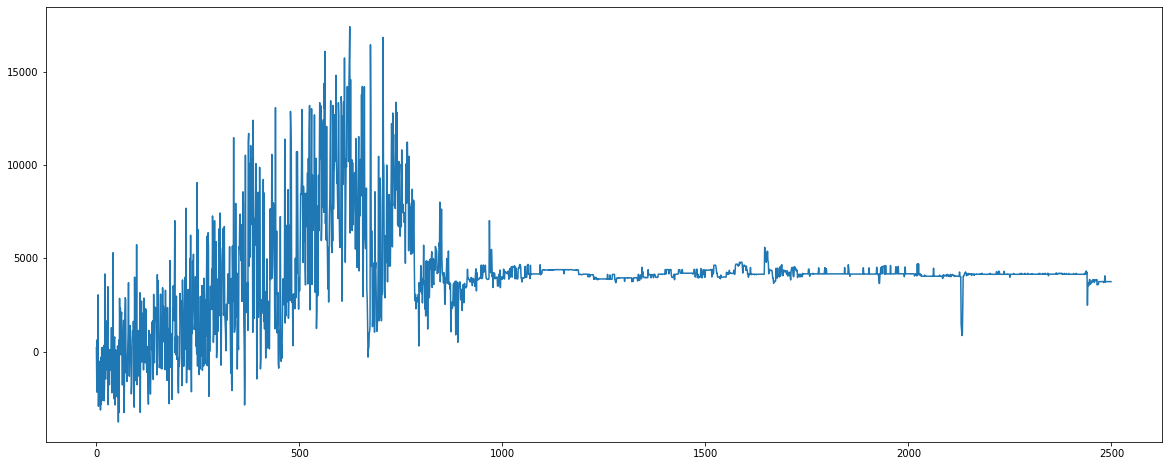

min reward: -3778.41680000002 max reward 17406.365 avg reward over 2500 epsiodes 4120.546175160001


In [17]:
#IBM data

ibm_q_table = train(ibm["close"].values, close_state, stock_state, cash_state, actions)

(305, 16, 25, 3)
finished episode 0 with 5960.600130999999 profits. random count: 1257 calculated count: 0
finished episode 1 with 3303.7501410000004 profits. random count: 1248 calculated count: 9
finished episode 2 with 4847.430194999999 profits. random count: 1234 calculated count: 23
finished episode 3 with 5139.069846000002 profits. random count: 1212 calculated count: 45
finished episode 4 with 6701.270381000004 profits. random count: 1207 calculated count: 50
finished episode 5 with 6627.83015 profits. random count: 1192 calculated count: 65
finished episode 6 with 3351.8099729999994 profits. random count: 1176 calculated count: 81
finished episode 7 with 7637.939631999998 profits. random count: 1163 calculated count: 94
finished episode 8 with 3948.1803130000008 profits. random count: 1150 calculated count: 107
finished episode 9 with 6446.879957999994 profits. random count: 1144 calculated count: 113
finished episode 10 with 7482.470122000002 profits. random count: 1128 calcul

finished episode 92 with 7566.000154000001 profits. random count: 506 calculated count: 751
finished episode 93 with 7212.4599910000015 profits. random count: 491 calculated count: 766
finished episode 94 with 6097.580157 profits. random count: 513 calculated count: 744
finished episode 95 with 6679.669447999999 profits. random count: 504 calculated count: 753
finished episode 96 with 7048.829579999998 profits. random count: 475 calculated count: 782
finished episode 97 with 6210.7403859999995 profits. random count: 443 calculated count: 814
finished episode 98 with 8148.159684 profits. random count: 489 calculated count: 768
finished episode 99 with 7003.090028999999 profits. random count: 424 calculated count: 833
finished episode 100 with 7078.360398000001 profits. random count: 451 calculated count: 806
finished episode 101 with 8856.650244000002 profits. random count: 448 calculated count: 809
finished episode 102 with 6295.289901 profits. random count: 466 calculated count: 791
f

finished episode 183 with 6514.429423999998 profits. random count: 204 calculated count: 1053
finished episode 184 with 7405.230126999999 profits. random count: 195 calculated count: 1062
finished episode 185 with 7840.899977000001 profits. random count: 198 calculated count: 1059
finished episode 186 with 5688.040077 profits. random count: 185 calculated count: 1072
finished episode 187 with 4828.750016 profits. random count: 192 calculated count: 1065
finished episode 188 with 7489.609998 profits. random count: 201 calculated count: 1056
finished episode 189 with 6231.499653999999 profits. random count: 166 calculated count: 1091
finished episode 190 with 7307.130452000001 profits. random count: 169 calculated count: 1088
finished episode 191 with 7654.759549999997 profits. random count: 182 calculated count: 1075
finished episode 192 with 5328.709824 profits. random count: 215 calculated count: 1042
finished episode 193 with 4374.169555000004 profits. random count: 183 calculated co

finished episode 273 with 5114.859487999998 profits. random count: 76 calculated count: 1181
finished episode 274 with 4496.280054999999 profits. random count: 73 calculated count: 1184
finished episode 275 with 4769.939907000004 profits. random count: 80 calculated count: 1177
finished episode 276 with 4298.249549999997 profits. random count: 75 calculated count: 1182
finished episode 277 with 4702.249849999998 profits. random count: 74 calculated count: 1183
finished episode 278 with 3208.2495499999986 profits. random count: 86 calculated count: 1171
finished episode 279 with 2462.1107490000004 profits. random count: 79 calculated count: 1178
finished episode 280 with 3247.5004499999995 profits. random count: 53 calculated count: 1204
finished episode 281 with 3072.249575 profits. random count: 74 calculated count: 1183
finished episode 282 with 1620.0595509999994 profits. random count: 66 calculated count: 1191
finished episode 283 with 3198.270028000001 profits. random count: 88 ca

finished episode 362 with 377.5099710000013 profits. random count: 25 calculated count: 1232
finished episode 363 with 187.9999999999991 profits. random count: 30 calculated count: 1227
finished episode 364 with 808.3100000000013 profits. random count: 39 calculated count: 1218
finished episode 365 with 422.55029999999806 profits. random count: 37 calculated count: 1220
finished episode 366 with 797.2499250000001 profits. random count: 28 calculated count: 1229
finished episode 367 with 407.7499749999988 profits. random count: 31 calculated count: 1226
finished episode 368 with 812.2801790000012 profits. random count: 32 calculated count: 1225
finished episode 369 with 216.88969999999608 profits. random count: 32 calculated count: 1225
finished episode 370 with 218.24959999999555 profits. random count: 21 calculated count: 1236
finished episode 371 with 1282.2504250000047 profits. random count: 36 calculated count: 1221
finished episode 372 with 1206.9202760000007 profits. random count

finished episode 452 with 256.99997500000063 profits. random count: 18 calculated count: 1239
finished episode 453 with 83.74972499999694 profits. random count: 13 calculated count: 1244
finished episode 454 with 210.99997499999972 profits. random count: 18 calculated count: 1239
finished episode 455 with 110.00010000000111 profits. random count: 10 calculated count: 1247
finished episode 456 with 132.5001000000011 profits. random count: 11 calculated count: 1246
finished episode 457 with 171.75002500000028 profits. random count: 14 calculated count: 1243
finished episode 458 with 199.0001250000014 profits. random count: 21 calculated count: 1236
finished episode 459 with 182.25030000000334 profits. random count: 13 calculated count: 1244
finished episode 460 with 181.00025000000278 profits. random count: 10 calculated count: 1247
finished episode 461 with 112.50010000000111 profits. random count: 12 calculated count: 1245
finished episode 462 with 201.0002250000025 profits. random cou

finished episode 542 with 103.50002500000028 profits. random count: 6 calculated count: 1251
finished episode 543 with 135.75037500000417 profits. random count: 10 calculated count: 1247
finished episode 544 with 167.00015000000167 profits. random count: 3 calculated count: 1254
finished episode 545 with 198.50020000000222 profits. random count: 7 calculated count: 1250
finished episode 546 with 270.0001250000023 profits. random count: 3 calculated count: 1254
finished episode 547 with 176.00007500000083 profits. random count: 6 calculated count: 1251
finished episode 548 with 475.25015000000167 profits. random count: 4 calculated count: 1253
finished episode 549 with 132.25007500000083 profits. random count: 2 calculated count: 1255
finished episode 550 with 161.7501000000011 profits. random count: 3 calculated count: 1254
finished episode 551 with 186.75 profits. random count: 8 calculated count: 1249
finished episode 552 with 298.75017500000195 profits. random count: 6 calculated co

finished episode 633 with 146.7502250000025 profits. random count: 2 calculated count: 1255
finished episode 634 with 137.0001000000011 profits. random count: 3 calculated count: 1254
finished episode 635 with 205.25020000000222 profits. random count: 5 calculated count: 1252
finished episode 636 with 270.00015000000167 profits. random count: 5 calculated count: 1252
finished episode 637 with 267.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 638 with 257.50030000000334 profits. random count: 2 calculated count: 1255
finished episode 639 with 267.75015000000167 profits. random count: 1 calculated count: 1256
finished episode 640 with 267.75015000000167 profits. random count: 1 calculated count: 1256
finished episode 641 with 267.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 642 with 246.50015000000167 profits. random count: 4 calculated count: 1253
finished episode 643 with 246.50017500000195 profits. random count: 1 ca

finished episode 723 with 229.4997749999975 profits. random count: 1 calculated count: 1256
finished episode 724 with 229.4997749999975 profits. random count: 0 calculated count: 1257
finished episode 725 with 229.4997749999975 profits. random count: 0 calculated count: 1257
finished episode 726 with 270.4997749999975 profits. random count: 1 calculated count: 1256
finished episode 727 with 229.4997749999975 profits. random count: 0 calculated count: 1257
finished episode 728 with 212.9997749999975 profits. random count: 2 calculated count: 1255
finished episode 729 with 227.2497749999975 profits. random count: 1 calculated count: 1256
finished episode 730 with 212.49982499999805 profits. random count: 1 calculated count: 1256
finished episode 731 with 235.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 732 with 215.99979999999778 profits. random count: 2 calculated count: 1255
finished episode 733 with 219.24972499999694 profits. random count: 1 calcula

finished episode 816 with 225.99982499999805 profits. random count: 1 calculated count: 1256
finished episode 817 with 214.49979999999778 profits. random count: 1 calculated count: 1256
finished episode 818 with 225.99982499999805 profits. random count: 0 calculated count: 1257
finished episode 819 with 225.99982499999805 profits. random count: 1 calculated count: 1256
finished episode 820 with 225.99982499999805 profits. random count: 1 calculated count: 1256
finished episode 821 with 225.99982499999805 profits. random count: 0 calculated count: 1257
finished episode 822 with 217.74982499999805 profits. random count: 1 calculated count: 1256
finished episode 823 with 225.99982499999805 profits. random count: 0 calculated count: 1257
finished episode 824 with 225.99982499999805 profits. random count: 0 calculated count: 1257
finished episode 825 with 225.99982499999805 profits. random count: 0 calculated count: 1257
finished episode 826 with 225.99982499999805 profits. random count: 1 

finished episode 905 with 313.2499749999997 profits. random count: 0 calculated count: 1257
finished episode 906 with 313.2499749999997 profits. random count: 1 calculated count: 1256
finished episode 907 with 295.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 908 with 313.2499749999997 profits. random count: 0 calculated count: 1257
finished episode 909 with 313.2499749999997 profits. random count: 0 calculated count: 1257
finished episode 910 with 313.2499749999997 profits. random count: 0 calculated count: 1257
finished episode 911 with 313.2499749999997 profits. random count: 0 calculated count: 1257
finished episode 912 with 295.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 913 with 313.2499749999997 profits. random count: 0 calculated count: 1257
finished episode 914 with 313.2499749999997 profits. random count: 0 calculated count: 1257
finished episode 915 with 313.2499749999997 profits. random count: 0 calculate

finished episode 994 with 196.74997499999972 profits. random count: 0 calculated count: 1257
finished episode 995 with 196.74997499999972 profits. random count: 1 calculated count: 1256
finished episode 996 with 196.74997499999972 profits. random count: 0 calculated count: 1257
finished episode 997 with 196.74997499999972 profits. random count: 0 calculated count: 1257
finished episode 998 with 196.74997499999972 profits. random count: 0 calculated count: 1257
finished episode 999 with 196.74997499999972 profits. random count: 0 calculated count: 1257
finished episode 1000 with 196.74997499999972 profits. random count: 1 calculated count: 1256
finished episode 1001 with 196.74997499999972 profits. random count: 0 calculated count: 1257
finished episode 1002 with 196.74997499999972 profits. random count: 0 calculated count: 1257
finished episode 1003 with 196.74997499999972 profits. random count: 0 calculated count: 1257
finished episode 1004 with 232.75 profits. random count: 1 calcula

finished episode 1083 with 273.50007500000083 profits. random count: 1 calculated count: 1256
finished episode 1084 with 213.7498999999989 profits. random count: 0 calculated count: 1257
finished episode 1085 with 213.7498999999989 profits. random count: 0 calculated count: 1257
finished episode 1086 with 228.24984999999833 profits. random count: 0 calculated count: 1257
finished episode 1087 with 261.00007500000083 profits. random count: 0 calculated count: 1257
finished episode 1088 with 289.50005000000056 profits. random count: 0 calculated count: 1257
finished episode 1089 with 302.50007500000083 profits. random count: 0 calculated count: 1257
finished episode 1090 with 289.50005000000056 profits. random count: 0 calculated count: 1257
finished episode 1091 with 289.50005000000056 profits. random count: 0 calculated count: 1257
finished episode 1092 with 289.50005000000056 profits. random count: 0 calculated count: 1257
finished episode 1093 with 289.50005000000056 profits. random 

finished episode 1172 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1173 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1174 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1175 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1176 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1177 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1178 with 100.75020000000222 profits. random count: 1 calculated count: 1256
finished episode 1179 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1180 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1181 with 126.50015000000167 profits. random count: 0 calculated count: 1257
finished episode 1182 with 126.50015000000167 profits. rando

finished episode 1261 with 185.75015000000167 profits. random count: 1 calculated count: 1256
finished episode 1262 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1263 with 184.25015000000167 profits. random count: 1 calculated count: 1256
finished episode 1264 with 185.75015000000167 profits. random count: 1 calculated count: 1256
finished episode 1265 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1266 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1267 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1268 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1269 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1270 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1271 with 185.75015000000167 profits. rando

finished episode 1349 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1350 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1351 with 185.75015000000167 profits. random count: 1 calculated count: 1256
finished episode 1352 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1353 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1354 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1355 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1356 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1357 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1358 with 185.75015000000167 profits. random count: 0 calculated count: 1257
finished episode 1359 with 185.75015000000167 profits. rando

finished episode 1438 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1439 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1440 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1441 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1442 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1443 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1444 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1445 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1446 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1447 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1448 with 205.7503250000036 profits. random count: 0 

finished episode 1530 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1531 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1532 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1533 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1534 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1535 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1536 with 205.7503250000036 profits. random count: 1 calculated count: 1256
finished episode 1537 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1538 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1539 with 205.7503250000036 profits. random count: 0 calculated count: 1257
finished episode 1540 with 205.7503250000036 profits. random count: 0 

finished episode 1623 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1624 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1625 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1626 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1627 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1628 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1629 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1630 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1631 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1632 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1633 with 288.5002500000028 profits. random count: 0 

finished episode 1714 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1715 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1716 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1717 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1718 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1719 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1720 with 286.2502500000028 profits. random count: 1 calculated count: 1256
finished episode 1721 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1722 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1723 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1724 with 288.5002500000028 profits. random count: 0 

finished episode 1803 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1804 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1805 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1806 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1807 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1808 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1809 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1810 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1811 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1812 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1813 with 288.5002500000028 profits. random count: 0 

finished episode 1896 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1897 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1898 with 291.0002250000025 profits. random count: 1 calculated count: 1256
finished episode 1899 with 327.0002500000028 profits. random count: 0 calculated count: 1257
finished episode 1900 with 288.5002500000028 profits. random count: 1 calculated count: 1256
finished episode 1901 with 286.2502500000028 profits. random count: 1 calculated count: 1256
finished episode 1902 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1903 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1904 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1905 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1906 with 288.5002500000028 profits. random count: 0 

finished episode 1987 with 288.5002500000028 profits. random count: 1 calculated count: 1256
finished episode 1988 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1989 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1990 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1991 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1992 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1993 with 292.7502500000028 profits. random count: 1 calculated count: 1256
finished episode 1994 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1995 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1996 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 1997 with 288.5002500000028 profits. random count: 0 

finished episode 2078 with 288.5002500000028 profits. random count: 1 calculated count: 1256
finished episode 2079 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 2080 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 2081 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 2082 with 288.5002500000028 profits. random count: 0 calculated count: 1257
finished episode 2083 with 240.50027500000306 profits. random count: 3 calculated count: 1254
finished episode 2084 with 173.75020000000222 profits. random count: 0 calculated count: 1257
finished episode 2085 with 154.7502250000025 profits. random count: 0 calculated count: 1257
finished episode 2086 with 167.2501000000011 profits. random count: 0 calculated count: 1257
finished episode 2087 with 173.00015000000167 profits. random count: 0 calculated count: 1257
finished episode 2088 with 218.25007500000083 profits. random count

finished episode 2168 with 1033.1900819999992 profits. random count: 0 calculated count: 1257
finished episode 2169 with 1059.8500559999993 profits. random count: 0 calculated count: 1257
finished episode 2170 with 1375.0999509999992 profits. random count: 0 calculated count: 1257
finished episode 2171 with 962.130051000001 profits. random count: 0 calculated count: 1257
finished episode 2172 with 943.4500750000016 profits. random count: 0 calculated count: 1257
finished episode 2173 with 921.4600750000009 profits. random count: 0 calculated count: 1257
finished episode 2174 with 1023.2800240000006 profits. random count: 0 calculated count: 1257
finished episode 2175 with 1053.3300250000011 profits. random count: 0 calculated count: 1257
finished episode 2176 with 1126.9101740000006 profits. random count: 0 calculated count: 1257
finished episode 2177 with 868.2801320000017 profits. random count: 0 calculated count: 1257
finished episode 2178 with 1061.900076 profits. random count: 0 c

finished episode 2261 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2262 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2263 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2264 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2265 with 1467.3999519999988 profits. random count: 1 calculated count: 1256
finished episode 2266 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2267 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2268 with 1470.0999009999978 profits. random count: 1 calculated count: 1256
finished episode 2269 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2270 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2271 with 1464.5299259999983 profits. rando

finished episode 2351 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2352 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2353 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2354 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2355 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2356 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2357 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2358 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2359 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2360 with 1467.3999519999988 profits. random count: 0 calculated count: 1257
finished episode 2361 with 1467.3999519999988 profits. rando

finished episode 2440 with 1367.889901999999 profits. random count: 0 calculated count: 1257
finished episode 2441 with 1279.519801999997 profits. random count: 0 calculated count: 1257
finished episode 2442 with 1279.519801999997 profits. random count: 0 calculated count: 1257
finished episode 2443 with 1279.519801999997 profits. random count: 1 calculated count: 1256
finished episode 2444 with 1366.6299009999993 profits. random count: 1 calculated count: 1256
finished episode 2445 with 1278.4097509999974 profits. random count: 0 calculated count: 1257
finished episode 2446 with 1278.2697769999977 profits. random count: 0 calculated count: 1257
finished episode 2447 with 1278.5198269999983 profits. random count: 0 calculated count: 1257
finished episode 2448 with 1316.3298009999971 profits. random count: 0 calculated count: 1257
finished episode 2449 with 1502.9302760000028 profits. random count: 0 calculated count: 1257
finished episode 2450 with 1514.0402260000028 profits. random co

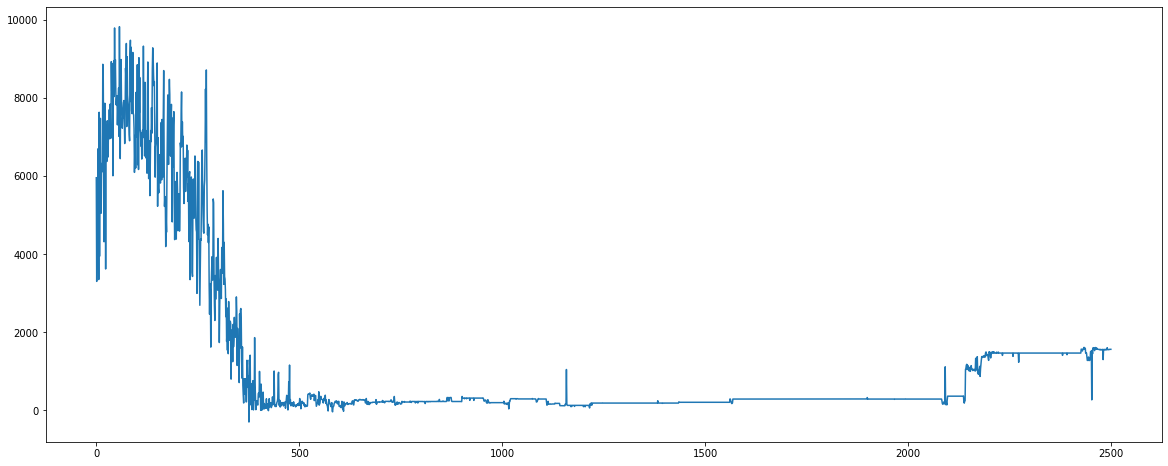

min reward: -300.2497749999984 max reward 9831.829892999998 avg reward over 2500 epsiodes 1212.9793355468012


In [27]:
# BOA data

boa_q_table = train(boa["Close"].values, close_state, stock_state, cash_state, actions)

(305, 16, 25, 3)
finished episode 0 with 796.6299689999978 profits. random count: 1257 calculated count: 0
finished episode 1 with 286.440464000003 profits. random count: 1244 calculated count: 13
finished episode 2 with 311.81059100000493 profits. random count: 1234 calculated count: 23
finished episode 3 with 935.329266999991 profits. random count: 1224 calculated count: 33
finished episode 4 with 2590.5599089999923 profits. random count: 1213 calculated count: 44
finished episode 5 with 2834.4010320000043 profits. random count: 1198 calculated count: 59
finished episode 6 with 1414.3497369999905 profits. random count: 1197 calculated count: 60
finished episode 7 with 1112.950907999999 profits. random count: 1172 calculated count: 85
finished episode 8 with 2377.1312310000067 profits. random count: 1153 calculated count: 104
finished episode 9 with 1646.6502979999977 profits. random count: 1151 calculated count: 106
finished episode 10 with 648.3605020000032 profits. random count: 11

finished episode 91 with 2499.651377 profits. random count: 488 calculated count: 769
finished episode 92 with 2359.900421000003 profits. random count: 525 calculated count: 732
finished episode 93 with 2225.760806000002 profits. random count: 484 calculated count: 773
finished episode 94 with 2232.490517 profits. random count: 493 calculated count: 764
finished episode 95 with 2148.5206820000003 profits. random count: 480 calculated count: 777
finished episode 96 with 1561.0607770000033 profits. random count: 486 calculated count: 771
finished episode 97 with 2271.250630000003 profits. random count: 464 calculated count: 793
finished episode 98 with 1692.849624999997 profits. random count: 451 calculated count: 806
finished episode 99 with 1508.1693779999969 profits. random count: 431 calculated count: 826
finished episode 100 with 2202.059613999999 profits. random count: 462 calculated count: 795
finished episode 101 with 1228.1397519999982 profits. random count: 474 calculated count

finished episode 179 with 1606.409901000001 profits. random count: 217 calculated count: 1040
finished episode 180 with 1563.089310999998 profits. random count: 198 calculated count: 1059
finished episode 181 with 1885.189561999994 profits. random count: 190 calculated count: 1067
finished episode 182 with 1349.1102460000002 profits. random count: 201 calculated count: 1056
finished episode 183 with 722.3409330000013 profits. random count: 197 calculated count: 1060
finished episode 184 with 2334.6300889999984 profits. random count: 191 calculated count: 1066
finished episode 185 with 1004.3197279999931 profits. random count: 191 calculated count: 1066
finished episode 186 with 1317.4701419999956 profits. random count: 208 calculated count: 1049
finished episode 187 with 1438.0804240000016 profits. random count: 204 calculated count: 1053
finished episode 188 with 1615.7709570000052 profits. random count: 200 calculated count: 1057
finished episode 189 with 1728.7405380000027 profits. 

finished episode 270 with 672.2001790000049 profits. random count: 85 calculated count: 1172
finished episode 271 with 1181.5010000000066 profits. random count: 84 calculated count: 1173
finished episode 272 with 1492.0005000000046 profits. random count: 82 calculated count: 1175
finished episode 273 with 829.120761000001 profits. random count: 67 calculated count: 1190
finished episode 274 with 1018.8102950000002 profits. random count: 91 calculated count: 1166
finished episode 275 with 1048.4992629999915 profits. random count: 92 calculated count: 1165
finished episode 276 with 405.04011099999934 profits. random count: 77 calculated count: 1180
finished episode 277 with 1955.1410480000122 profits. random count: 74 calculated count: 1183
finished episode 278 with 1180.2008900000037 profits. random count: 66 calculated count: 1191
finished episode 279 with 1832.4601619999994 profits. random count: 74 calculated count: 1183
finished episode 280 with 744.8698019999947 profits. random cou

finished episode 362 with 136.49949999999444 profits. random count: 33 calculated count: 1224
finished episode 363 with -227.99974999999813 profits. random count: 30 calculated count: 1227
finished episode 364 with 845.2499500000004 profits. random count: 22 calculated count: 1235
finished episode 365 with 334.49992499999917 profits. random count: 29 calculated count: 1228
finished episode 366 with 275.50005000000056 profits. random count: 26 calculated count: 1231
finished episode 367 with 451.50015000000167 profits. random count: 30 calculated count: 1227
finished episode 368 with 1019.0299499999983 profits. random count: 27 calculated count: 1230
finished episode 369 with 1036.000350000003 profits. random count: 31 calculated count: 1226
finished episode 370 with -140.99972499999512 profits. random count: 32 calculated count: 1225
finished episode 371 with 327.75025000000096 profits. random count: 26 calculated count: 1231
finished episode 372 with 199.24949999999444 profits. random

finished episode 453 with -12.749849999998332 profits. random count: 19 calculated count: 1238
finished episode 454 with 165.24957499999527 profits. random count: 14 calculated count: 1243
finished episode 455 with 245.2503500000039 profits. random count: 15 calculated count: 1242
finished episode 456 with 353.25015000000167 profits. random count: 13 calculated count: 1244
finished episode 457 with -40.75025000000278 profits. random count: 15 calculated count: 1242
finished episode 458 with -10.749924999999166 profits. random count: 7 calculated count: 1250
finished episode 459 with 61.49964999999611 profits. random count: 10 calculated count: 1247
finished episode 460 with 89.50007499999992 profits. random count: 9 calculated count: 1248
finished episode 461 with 137.4998749999986 profits. random count: 11 calculated count: 1246
finished episode 462 with 32.999949999999444 profits. random count: 11 calculated count: 1246
finished episode 463 with 50.50010000000111 profits. random coun

finished episode 547 with 77.75 profits. random count: 4 calculated count: 1253
finished episode 548 with -1.7497999999977765 profits. random count: 3 calculated count: 1254
finished episode 549 with 81.50007500000083 profits. random count: 7 calculated count: 1250
finished episode 550 with 112.00007500000083 profits. random count: 6 calculated count: 1251
finished episode 551 with 24.249974999999722 profits. random count: 5 calculated count: 1252
finished episode 552 with 60.250050000000556 profits. random count: 4 calculated count: 1253
finished episode 553 with 67.24982499999805 profits. random count: 4 calculated count: 1253
finished episode 554 with 72.49992499999917 profits. random count: 5 calculated count: 1252
finished episode 555 with 107.25005000000056 profits. random count: 5 calculated count: 1252
finished episode 556 with 191.0001000000011 profits. random count: 5 calculated count: 1252
finished episode 557 with 67.75002500000028 profits. random count: 7 calculated count:

finished episode 640 with 176.49997499999972 profits. random count: 2 calculated count: 1255
finished episode 641 with 162.74994999999944 profits. random count: 2 calculated count: 1255
finished episode 642 with 190.24997499999972 profits. random count: 1 calculated count: 1256
finished episode 643 with 169.74992499999917 profits. random count: 2 calculated count: 1255
finished episode 644 with 384.49962499999583 profits. random count: 2 calculated count: 1255
finished episode 645 with 361.4997499999972 profits. random count: 1 calculated count: 1256
finished episode 646 with 358.9997499999972 profits. random count: 1 calculated count: 1256
finished episode 647 with 350.74984999999833 profits. random count: 4 calculated count: 1253
finished episode 648 with 327.74972499999694 profits. random count: 1 calculated count: 1256
finished episode 649 with 336.49972499999694 profits. random count: 0 calculated count: 1257
finished episode 650 with 336.49972499999694 profits. random count: 0 ca

finished episode 734 with 118.99997499999972 profits. random count: 1 calculated count: 1256
finished episode 735 with 118.99997499999972 profits. random count: 1 calculated count: 1256
finished episode 736 with 118.99997499999972 profits. random count: 1 calculated count: 1256
finished episode 737 with 118.99997499999972 profits. random count: 0 calculated count: 1257
finished episode 738 with 131.25002500000028 profits. random count: 2 calculated count: 1255
finished episode 739 with 118.99997499999972 profits. random count: 1 calculated count: 1256
finished episode 740 with 118.99997499999972 profits. random count: 1 calculated count: 1256
finished episode 741 with 118.99997499999972 profits. random count: 0 calculated count: 1257
finished episode 742 with 118.99997499999972 profits. random count: 0 calculated count: 1257
finished episode 743 with 118.99997499999972 profits. random count: 1 calculated count: 1256
finished episode 744 with 118.99997499999972 profits. random count: 0 

finished episode 824 with 12.250025000000278 profits. random count: 0 calculated count: 1257
finished episode 825 with 6.749974999999722 profits. random count: 0 calculated count: 1257
finished episode 826 with -57.0002250000025 profits. random count: 0 calculated count: 1257
finished episode 827 with 102.24989999999889 profits. random count: 1 calculated count: 1256
finished episode 828 with 104.75 profits. random count: 1 calculated count: 1256
finished episode 829 with -20.250025000000278 profits. random count: 0 calculated count: 1257
finished episode 830 with -0.7500250000002779 profits. random count: 0 calculated count: 1257
finished episode 831 with -20.250025000000278 profits. random count: 0 calculated count: 1257
finished episode 832 with -0.7500250000002779 profits. random count: 1 calculated count: 1256
finished episode 833 with -20.250025000000278 profits. random count: 0 calculated count: 1257
finished episode 834 with -20.250025000000278 profits. random count: 0 calculat

finished episode 917 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 918 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 919 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 920 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 921 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 922 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 923 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 924 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 925 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 926 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 927 with 60.74989999999889 profits. random count: 0 calculated 

finished episode 1006 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1007 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1008 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1009 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1010 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1011 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1012 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1013 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1014 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1015 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1016 with 60.74989999999889 profits. random count: 0 

finished episode 1100 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1101 with 60.74989999999889 profits. random count: 1 calculated count: 1256
finished episode 1102 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1103 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1104 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1105 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1106 with 58.49989999999889 profits. random count: 1 calculated count: 1256
finished episode 1107 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1108 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1109 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1110 with 60.74989999999889 profits. random count: 0 

finished episode 1191 with 27.99989999999889 profits. random count: 1 calculated count: 1256
finished episode 1192 with 60.74989999999889 profits. random count: 1 calculated count: 1256
finished episode 1193 with 60.74989999999889 profits. random count: 1 calculated count: 1256
finished episode 1194 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1195 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1196 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1197 with 60.74989999999889 profits. random count: 1 calculated count: 1256
finished episode 1198 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1199 with 60.74989999999889 profits. random count: 0 calculated count: 1257
finished episode 1200 with 57.49987499999861 profits. random count: 1 calculated count: 1256
finished episode 1201 with 60.74989999999889 profits. random count: 0 

finished episode 1283 with 26.49987499999861 profits. random count: 0 calculated count: 1257
finished episode 1284 with 42.49984999999833 profits. random count: 0 calculated count: 1257
finished episode 1285 with 42.49984999999833 profits. random count: 0 calculated count: 1257
finished episode 1286 with 26.49987499999861 profits. random count: 0 calculated count: 1257
finished episode 1287 with 42.49984999999833 profits. random count: 0 calculated count: 1257
finished episode 1288 with 42.49984999999833 profits. random count: 0 calculated count: 1257
finished episode 1289 with 42.49984999999833 profits. random count: 0 calculated count: 1257
finished episode 1290 with 42.49984999999833 profits. random count: 0 calculated count: 1257
finished episode 1291 with 42.49984999999833 profits. random count: 0 calculated count: 1257
finished episode 1292 with 42.49984999999833 profits. random count: 0 calculated count: 1257
finished episode 1293 with 42.49984999999833 profits. random count: 0 

finished episode 1375 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1376 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1377 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1378 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1379 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1380 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1381 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1382 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1383 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1384 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1385 with 59.24989999999889 profits. random count: 0 

finished episode 1464 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1465 with 59.24989999999889 profits. random count: 0 calculated count: 1257
finished episode 1466 with 138.0002250000025 profits. random count: 1 calculated count: 1256
finished episode 1467 with 59.24989999999889 profits. random count: 1 calculated count: 1256
finished episode 1468 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1469 with 58.999949999999444 profits. random count: 0 calculated count: 1257
finished episode 1470 with 58.999949999999444 profits. random count: 0 calculated count: 1257
finished episode 1471 with -16.749974999999722 profits. random count: 0 calculated count: 1257
finished episode 1472 with 168.75040000000445 profits. random count: 0 calculated count: 1257
finished episode 1473 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1474 with 62.99989999999889 profits. random coun

finished episode 1555 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1556 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1557 with 66.74997499999972 profits. random count: 1 calculated count: 1256
finished episode 1558 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1559 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1560 with 57.249924999999166 profits. random count: 0 calculated count: 1257
finished episode 1561 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1562 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1563 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1564 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1565 with 62.99989999999889 profits. random count: 0

finished episode 1647 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1648 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1649 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1650 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1651 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1652 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1653 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1654 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1655 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1656 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1657 with 62.99989999999889 profits. random count: 1 

finished episode 1736 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1737 with 30.24964999999611 profits. random count: 1 calculated count: 1256
finished episode 1738 with 51.25025000000369 profits. random count: 0 calculated count: 1257
finished episode 1739 with 62.99989999999889 profits. random count: 1 calculated count: 1256
finished episode 1740 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1741 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1742 with 56.249924999999166 profits. random count: 1 calculated count: 1256
finished episode 1743 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1744 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1745 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1746 with 62.99989999999889 profits. random count: 0

finished episode 1828 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1829 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1830 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1831 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1832 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1833 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1834 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1835 with 62.99989999999889 profits. random count: 1 calculated count: 1256
finished episode 1836 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1837 with 57.99987499999861 profits. random count: 1 calculated count: 1256
finished episode 1838 with 62.99989999999889 profits. random count: 0 

finished episode 1918 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1919 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1920 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1921 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1922 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1923 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1924 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1925 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1926 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1927 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 1928 with 60.49989999999889 profits. random count: 1 

finished episode 2008 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2009 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2010 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2011 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2012 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2013 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2014 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2015 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2016 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2017 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2018 with 62.99989999999889 profits. random count: 0 

finished episode 2100 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2101 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2102 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2103 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2104 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2105 with 62.99989999999889 profits. random count: 1 calculated count: 1256
finished episode 2106 with 62.99989999999889 profits. random count: 1 calculated count: 1256
finished episode 2107 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2108 with 62.99989999999889 profits. random count: 1 calculated count: 1256
finished episode 2109 with 62.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2110 with 62.99989999999889 profits. random count: 0 

finished episode 2190 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2191 with 86.99989999999889 profits. random count: 1 calculated count: 1256
finished episode 2192 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2193 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2194 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2195 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2196 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2197 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2198 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2199 with 86.99989999999889 profits. random count: 0 calculated count: 1257
finished episode 2200 with 86.99989999999889 profits. random count: 0 

finished episode 2281 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2282 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2283 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2284 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2285 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2286 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2287 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2288 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2289 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2290 with 125.74987499999861 profits. random count: 0 calculated count: 1257
finished episode 2291 with 125.74987499999861 profits. rando

finished episode 2374 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2375 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2376 with 36.74972499999694 profits. random count: 1 calculated count: 1256
finished episode 2377 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2378 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2379 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2380 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2381 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2382 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2383 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2384 with 36.74972499999694 profits. random count: 0 

finished episode 2465 with 37.24974999999722 profits. random count: 1 calculated count: 1256
finished episode 2466 with 36.74972499999694 profits. random count: 1 calculated count: 1256
finished episode 2467 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2468 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2469 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2470 with 36.74972499999694 profits. random count: 1 calculated count: 1256
finished episode 2471 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2472 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2473 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2474 with 36.74972499999694 profits. random count: 0 calculated count: 1257
finished episode 2475 with 36.74972499999694 profits. random count: 0 

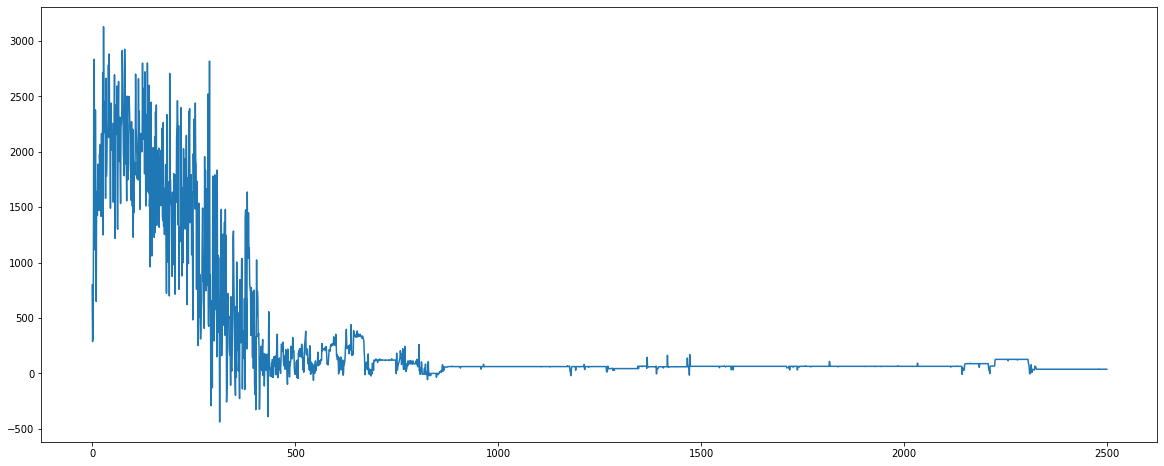

min reward: -439.74987200000305 max reward 3128.3907940000054 avg reward over 2500 epsiodes 293.63213171919915


In [19]:
# GE data

ge_q_table = train(ge["Close"].values, close_state, stock_state, cash_state, actions)

In [20]:
def test(f_data,q_table,close_state,stock_state,cash_state,actions):
    """ tests the perfomance of the agent based on the q table that was obtained during the training period
    """

    port_vals = []
    port_vals.append(5000) 

    buy_pt = []
    sell_pt= []

    portfolio = Portfolio(close_state, cash_state, stock_state)
    
    buy_amount=25
    sell_amount=25

    for i,close in enumerate(f_data):
        #get state
        state = (portfolio.get_close(close),portfolio.get_stock(), portfolio.get_cash())
        state_index = [close_state.get_state_index(state[0]),stock_state.get_state_index(state[1]),cash_state.get_state_index(state[2])] #index of state combination in q table

        #take action
        act = np.argmax(q_table[state_index[0]][state_index[1]][state_index[2]])
        
        if act == 0:
            #buy
            portfolio.buy(close,buy_amount)
            buy_pt.append(i)
        elif act == 1:
            #sell
            portfolio.sell(close,sell_amount)
            sell_pt.append(i)
        else:
            #hold, do nothing
            portfolio.hold()

        #asess portfolio value
        port_vals.append(portfolio.get_portfolio_value(close))


    buy_pt = np.array([[i,port_vals[i]] for i in buy_pt ])
    sell_pt = np.array([[i,port_vals[i]] for i in sell_pt ])


    plt.figure(figsize=(40,8))
    plt.plot(range(len(port_vals)),port_vals,c='black')
    plt.scatter(buy_pt.transpose()[0],buy_pt.transpose()[1],c='green')
    plt.scatter(sell_pt.transpose()[0],sell_pt.transpose()[1],c='red')
    plt.show()

    plt.figure(figsize=(40,8))
    plt.plot(range(len(f_data)),f_data)
    plt.show()
    

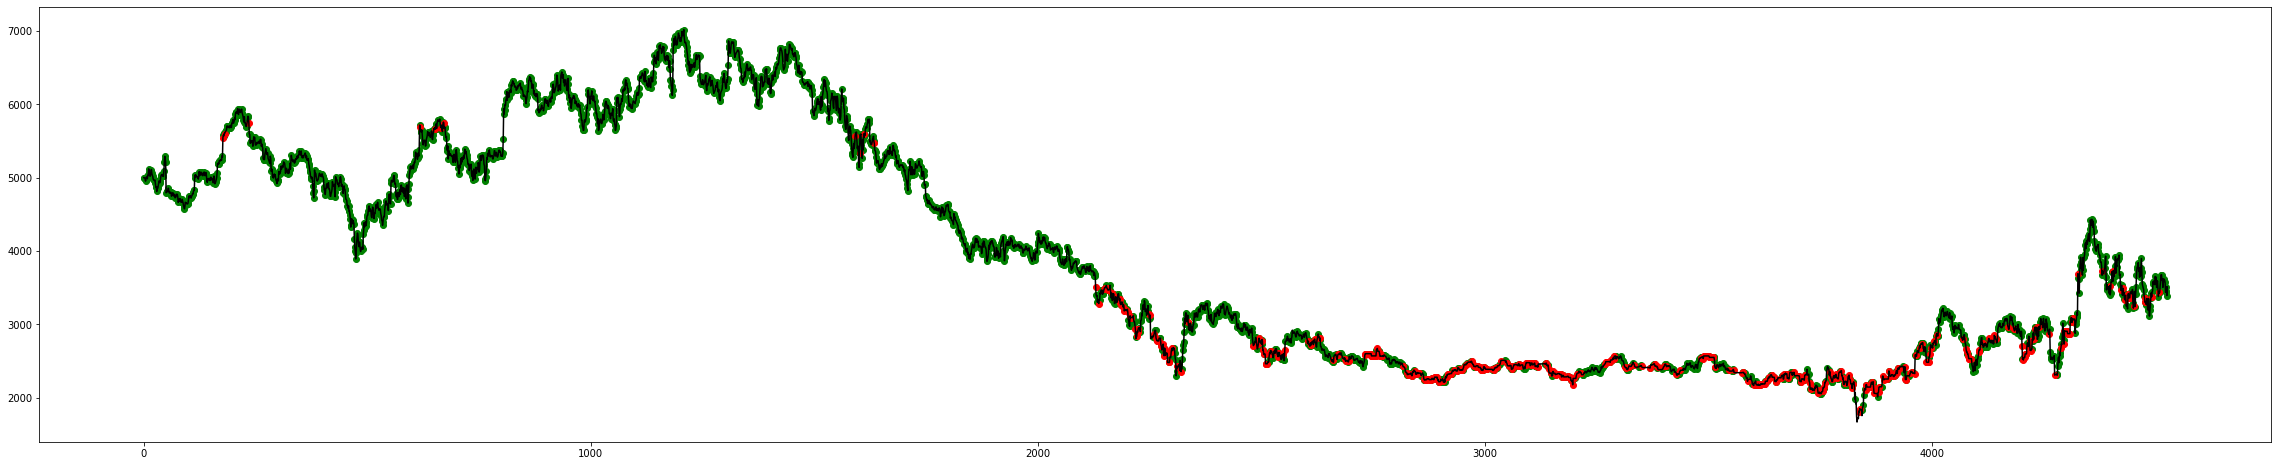

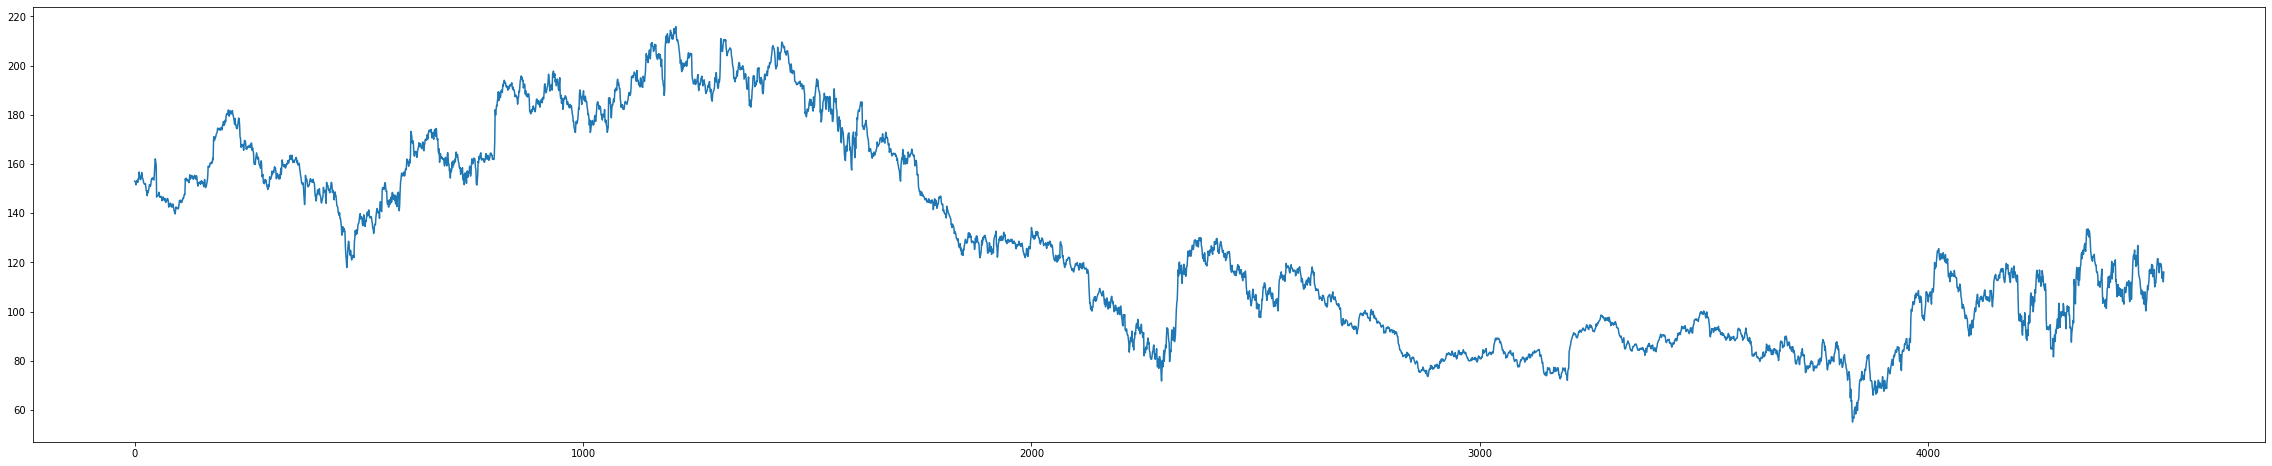

In [21]:
#testing ibm model

test(ibm["close"],ibm_q_table,close_state, stock_state, cash_state, actions)

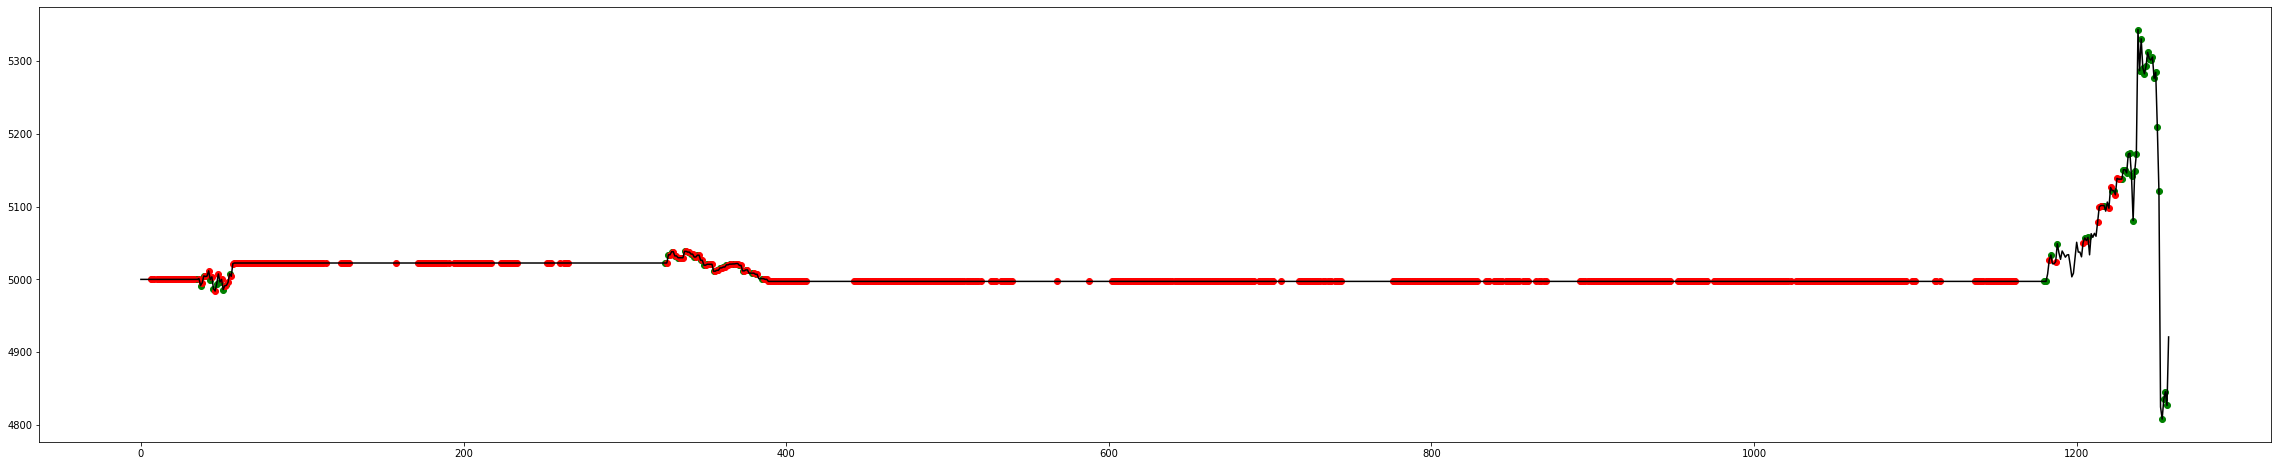

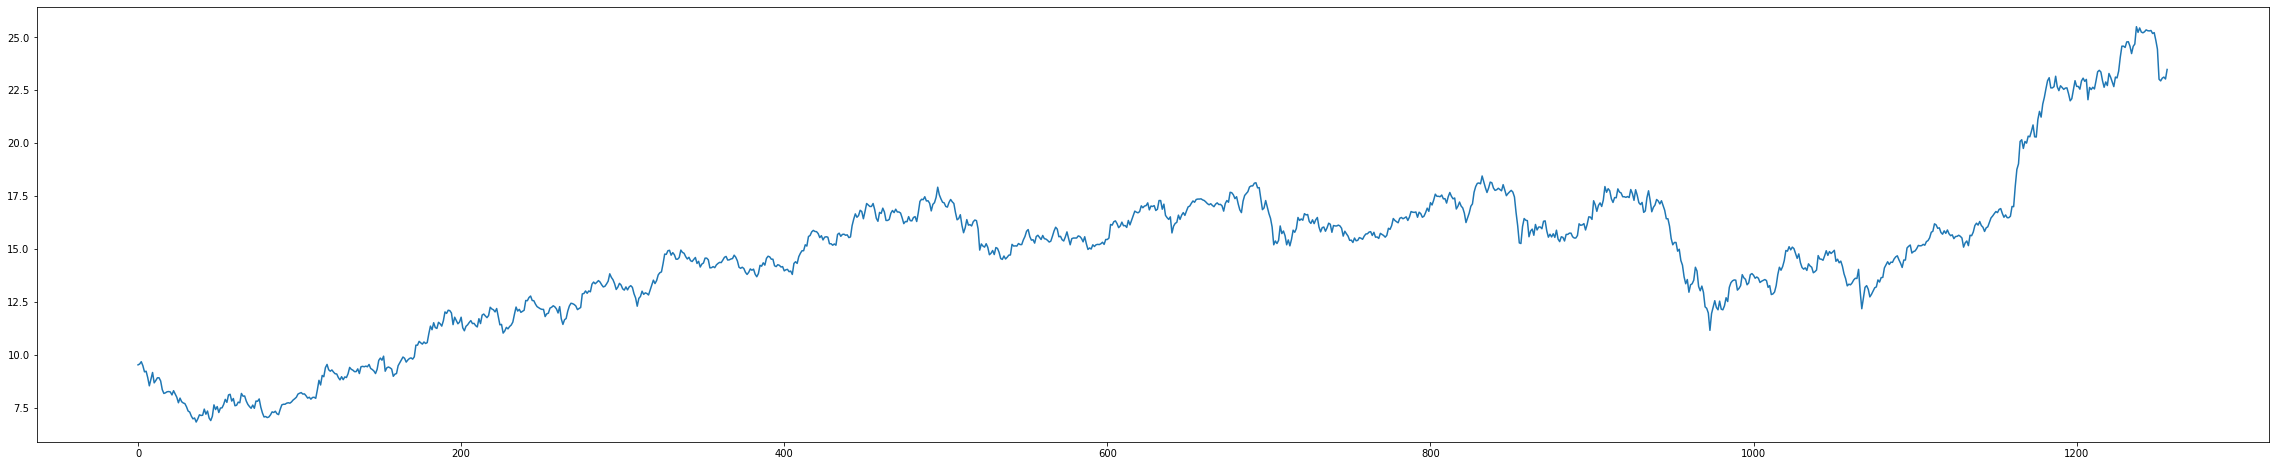

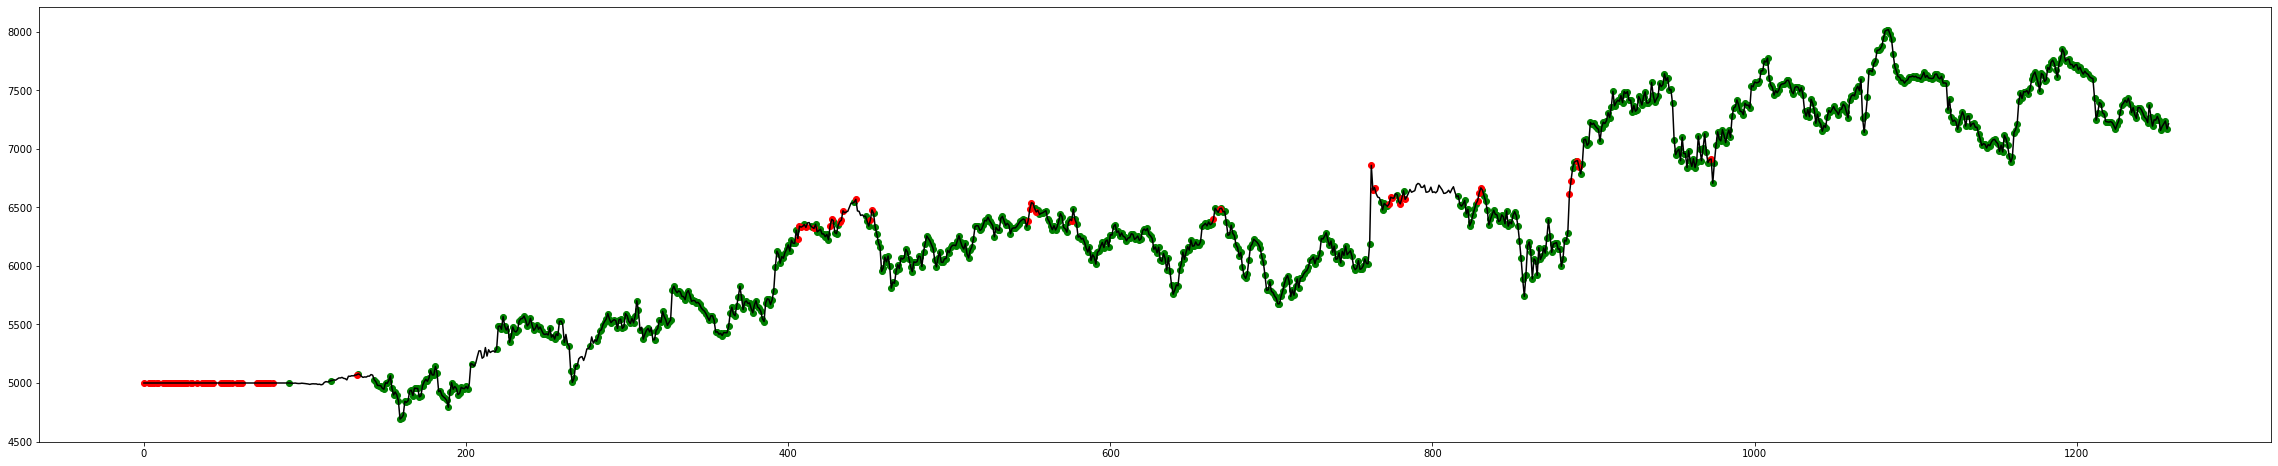

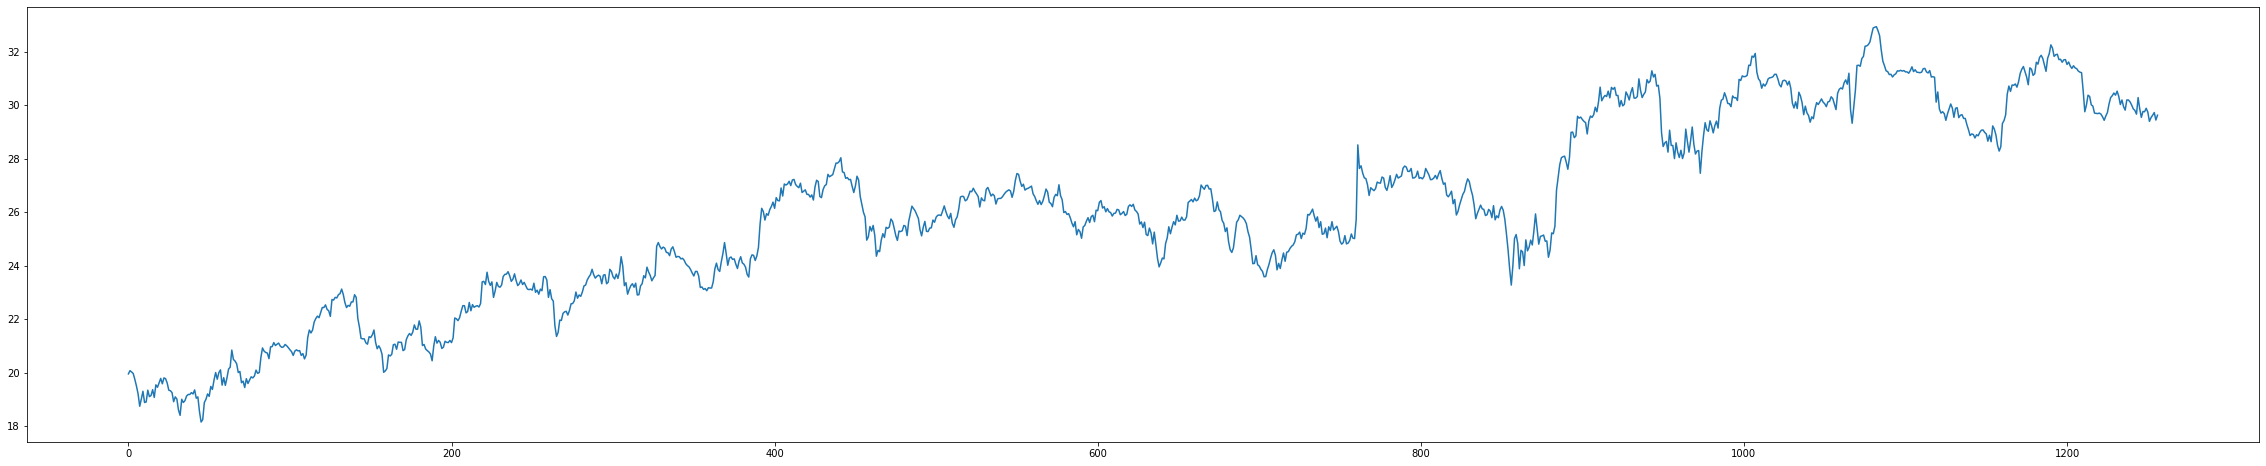

In [22]:
#testing boa model

test(boa["Close"],boa_q_table,close_state, stock_state, cash_state, actions)
test(ge["Close"],boa_q_table,close_state, stock_state, cash_state, actions)


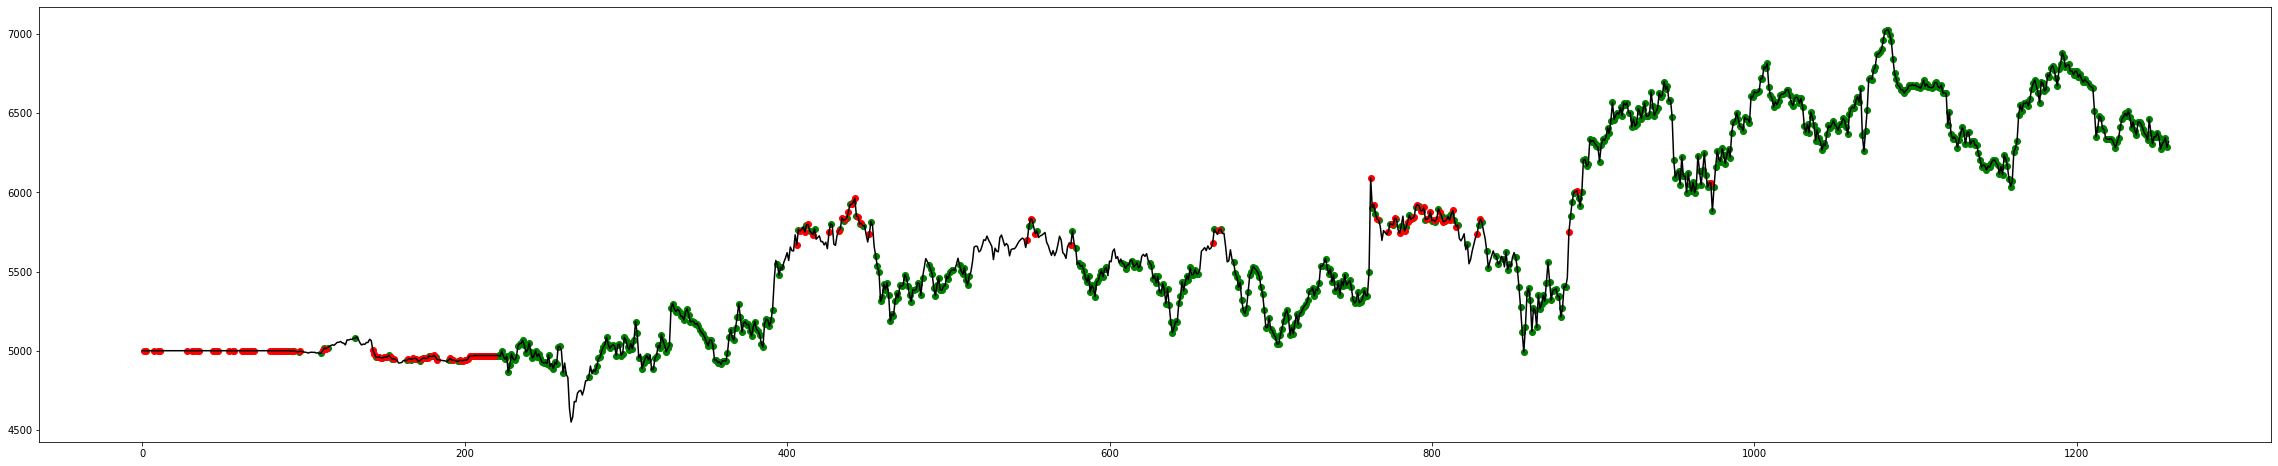

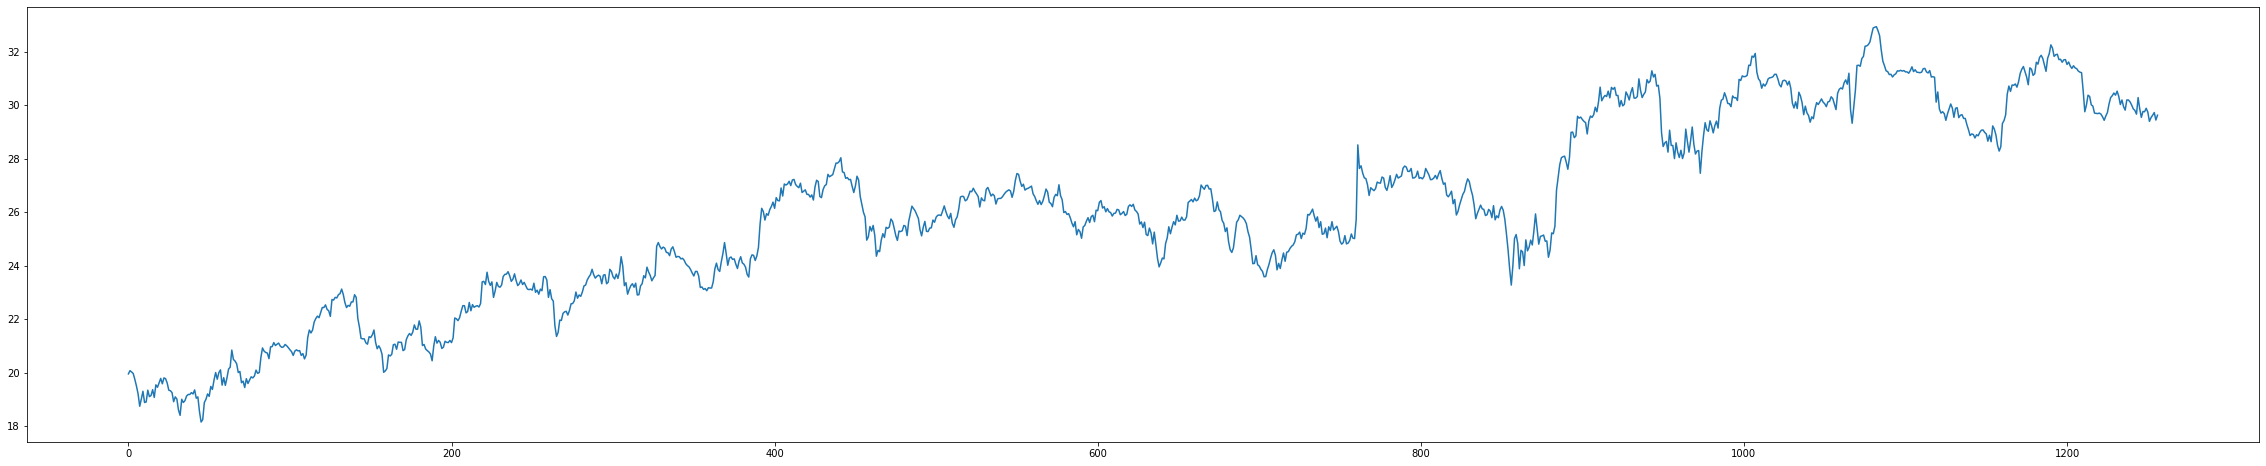

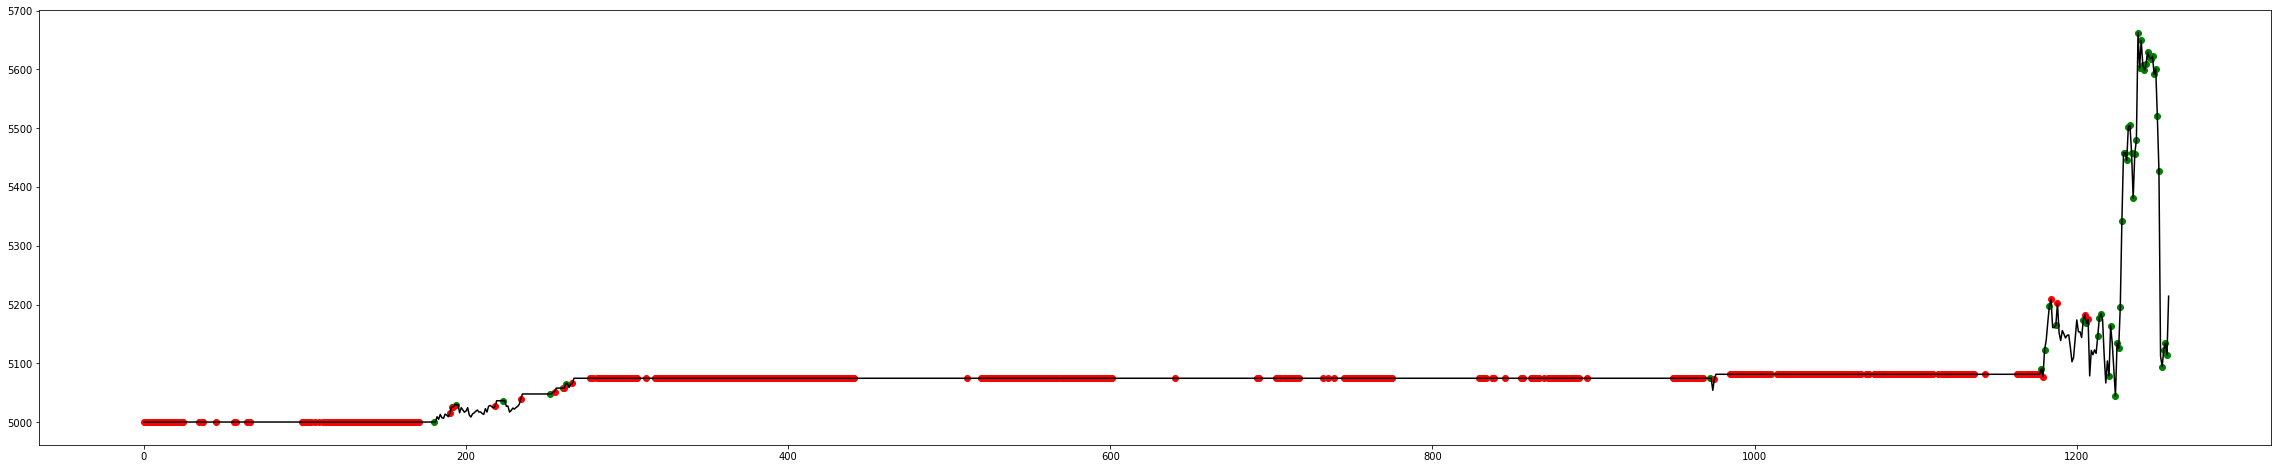

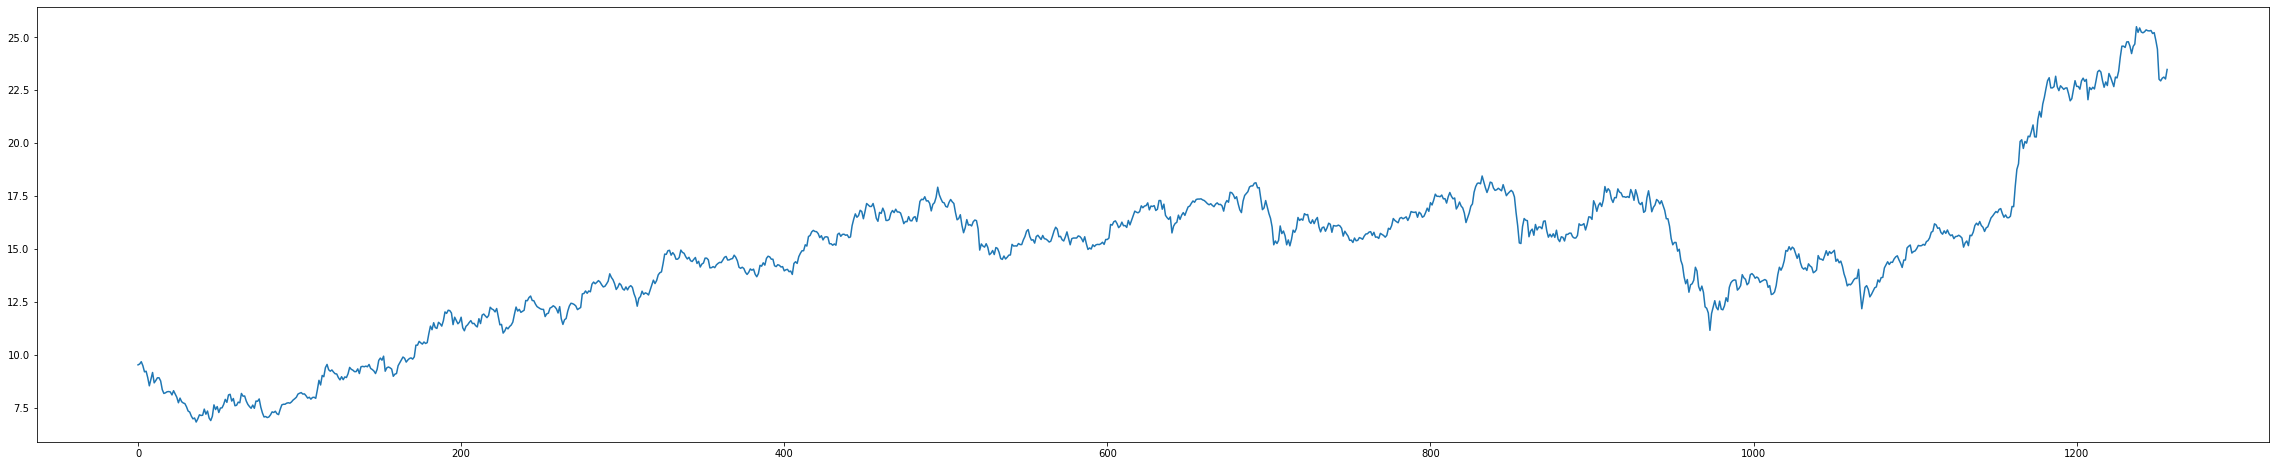

In [23]:
#testing the ge model


test(ge["Close"],ge_q_table,close_state, stock_state, cash_state, actions)
test(boa["Close"],ge_q_table,close_state, stock_state, cash_state, actions)


### Examining the results

So we can see from the results above that the agent ends up making some form of profit in the end, the training phase is very noisy and it almost looks like the agent acts randomly. However, we do see that over time, the noise tends to decrease and become more and more stable, meaning that the agent has found a suitable policy

In [24]:
print(q_table[6][1])

0.0


In [25]:
print(boa_q_table[:70])
print(ge_q_table[-70:])

[[[[    0.             0.             0.        ]
   [    0.             0.             0.        ]
   [    0.           983.18370287  1539.64348529]
   ...
   [    0.             0.             0.        ]
   [    0.             0.             0.        ]
   [    0.             0.             0.        ]]

  [[    0.             0.             0.        ]
   [ 5552.05705948     0.             0.        ]
   [ 3861.10533847  3629.69049848  3684.15404929]
   ...
   [    0.             0.             0.        ]
   [    0.             0.             0.        ]
   [    0.             0.             0.        ]]

  [[    0.             0.         10956.42589102]
   [10289.5065412   9198.17769206 12015.01055374]
   [ 9136.8492046   9076.71335792  9373.80355753]
   ...
   [    0.             0.             0.        ]
   [    0.             0.             0.        ]
   [ 4277.41863199     0.             0.        ]]

  ...

  [[    0.             0.             0.        ]
   [    0.      